# About this Notebook

The purpose of this notebook is to bring a first approach on the magnetic compensation of the carrier. In a first step, we realize a phase of exploration with the trajectory of the flights and the location of the different sections as well as some general information on the dataset. We will also see the different magnetic cards available and their differences.<br> 
We will also see the position of the diferent sensors in the plane to have an idea of their coverage. An animation is available to visualize the direction of the magnetic field measured by the vector magnetometers during the flight. An exploitation of the events during the flight is also realized to try to show a relation between the magnetic measurements and the different elements of the plane.<br>
A first correction of the data will then be realized by showing the impact of these corrections. Then comes a last step of selection of the features for our model as well as some precautions to take with regard to the data available for training.

# Table of contents

* [0 - Dataset general informations](#0)
    * [0.1 - Time, number of data and sampling frequency](#0.1)

# Import packages

In [1]:
import ipywidgets as widgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import random
from ipyleaflet import Map, LocalTileLayer, Polyline, LegendControl, ScaleControl
from ipywidgets import Layout
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
import time
import datetime
from scipy import signal
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import copy
from tabulate import tabulate

from anomaly_maps import ChallMagMap
import ppigrf
import magnav

In [2]:
# Larger view width

from IPython.display import display, HTML
display(HTML('<style>.container{width:75% !important; }</style>'))

# 0 - Dataset general informations <a class="anchor" id = "0"></a>

This dataset has 4 different flights :
- 1002 - Flight at 3000 meters of altitude. It includes the calibration flights as well as different elements aiming at disturbung the virtual dipole of the place
- 1003 - Flight at 400/800 meters of altitude. The goal of this flight was to collect free flight data over several hours.
- 1004 - Flight at 800 meters of altitude over Eastern free flight area. The goal of this flight is to create a high resolution map of the area.
- 1005 - Same as flight 1004 with a higher altitude. Due to weather concern, data collection was split in 2.

Each flight contains lines that are intended to segment the flight into different parts. We have a lot of differents measurements including magnetometers. Truth data here is __"IGRFMAG1"__, the magnetometer 1 at tail stinger compensated by SGL (Geological Survey company).

## 0.1 - Time, number of data and sampling frequency <a class="anchor" id = "0.1"></a>

In [3]:
# Extract sampling frequency, duration and number of data collected from the dataset

for n in range(2,6):
    
    df    = pd.read_hdf('../data/interim/Flt_data.h5', key=f'Flt100{n}')
    lines = df.LINE.unique()

    total_duration  = 0
    total_data      = 0
    total_freq_samp = 0

    for l in lines :

        df_lines = pd.DataFrame()
        mask     = (df.LINE == l)
        df_lines = pd.concat([df_lines,df.loc[mask]],axis=0)

        freq_samp = magnav.sampling_frequency(df_lines)
        nb_data   = np.shape(df_lines)[0]
        duration = nb_data*(1/freq_samp)

        total_duration  += duration
        total_data      += np.shape(df_lines)[0]
        total_freq_samp += freq_samp/len(lines)
        total_lines      = len(lines)

    
    print(f'Flight : 100{n} | Total flight time : {magnav.to_hms(total_duration)} | Number of data collected : {total_data} | Sampling frequency : {total_freq_samp:.2f}Hz | Number of unique flight lines : {total_lines}')
    
del df,lines,df_lines,mask

Flight : 1002 | Total flight time : 05h:45m:55s | Number of data collected : 207578 | Sampling frequency : 10.00Hz | Number of unique flight lines : 28
Flight : 1003 | Total flight time : 04h:26m:42s | Number of data collected : 160030 | Sampling frequency : 10.00Hz | Number of unique flight lines : 10
Flight : 1004 | Total flight time : 02h:15m:38s | Number of data collected : 81408 | Sampling frequency : 10.00Hz | Number of unique flight lines : 21
Flight : 1005 | Total flight time : 02h:16m:12s | Number of data collected : 81731 | Sampling frequency : 10.00Hz | Number of unique flight lines : 10


<font size="4">Interpretation of results :</font><br>
Due to the amount of data and the nature of the flights, the training and testing on flights 1002 and 1003 seems more relevant. Flights 1004 and 1005 are still relevant for data analysis.

## 0.2 - Flights datasets

In [4]:
df1002 = pd.read_hdf('../data/interim/Flt_data.h5', key=f'Flt1002')
df1003 = pd.read_hdf('../data/interim/Flt_data.h5', key=f'Flt1003')
df1004 = pd.read_hdf('../data/interim/Flt_data.h5', key=f'Flt1004')
df1005 = pd.read_hdf('../data/interim/Flt_data.h5', key=f'Flt1005')

# 1 - Select a flight

To better understand the data, it is important to first visualize the trajectories. In the following cells, we can select the flight we are interested in and sections of the flight.

## 1.1 - Flight number

In [5]:
# Create a widget to select the flight to load

w_flight = widgets.ToggleButtons(
    options=[('1002', 2), ('1003', 3), ('1004', 4), ('1005', 5)],
    value=3,
    description='Load flight')
display(w_flight)

ToggleButtons(description='Load flight', index=1, options=(('1002', 2), ('1003', 3), ('1004', 4), ('1005', 5))…

In [6]:
df_sel_flight = eval('df100'+str(w_flight.value))

## 1.2 - Flight section

In [7]:
# Create a widget to select the line(s) of the selected flight

w_lines = widgets.SelectMultiple(
    options     = df_sel_flight.LINE.unique(),
    description = 'Select line(s):',
    disabled    = False)
display(w_lines)

SelectMultiple(description='Select line(s):', options=(1003.01, 1003.02, 1003.03, 1003.04, 1003.05, 1003.06, 1…

In [8]:
# Extracting selected line(s) from the dataset

df_sel_lines = pd.DataFrame()
for line in w_lines.value:
    mask     = (df_sel_flight.LINE == line)
    df_sel_lines = pd.concat([df_sel_lines,df_sel_flight.loc[mask]],axis=0)

duration = np.shape(df_sel_lines)[0]*(1/freq_samp)

print(f'Rows : {np.shape(df_sel_lines)[0]} | Columns : {np.shape(df_sel_lines)[1]} | Duration : {magnav.to_hms(duration)}\n')

Rows : 160030 | Columns : 92 | Duration : 04h:26m:41s



# 2 - Map view

## 2.1 - OpenStreetMap

In [9]:
# Does not work on jupyter lab

m = Map(center   = [45.1278, -75.5120],
        zoom     = 8,
        max_zoom = 12,
        min_zoom = 8,
        layout   = Layout(width='100%',height='800px'))

m.add_layer(LocalTileLayer(path="../data/external/tiles/{z}/{x}/{y}.png"))

legend = LegendControl({},name="Legend",position="topright")
step = 10 
for line in w_lines.value:
    color = magnav.get_random_color()
    mask = (df_sel_flight.LINE == line)
    locations = (df_sel_flight
                 .loc[mask,['LAT','LONG']][::step]
                 .values
                 .tolist())
    pline = Polyline(
        locations = locations,
        color     = color,
        fill      = False,
        opacity   = 1)
    m.add_layer(pline)
    legend.add_legend_element(str(line),color)

m.add_control(legend)
m.add_control(ScaleControl(position='bottomleft'))

m

Map(center=[45.1278, -75.512], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

## 2.3 - Magnetic anomaly maps

### 2.3.1 - What's a magnetic anomaly map ?

A magnetic anomaly is a local variation in the Earth's magnetic field resulting from variations in the chemistry or magnetism of the rocks. These anomalies are then put in the form of maps and can be used as reference for navigation.<br><br>
![](../data/external/Images/WDMAM.png)

In [10]:
# Load anomaly maps

EasternMap = ChallMagMap('../data/raw/Eastern_2.h5')
RenfrewMap = ChallMagMap('../data/raw/Renfrew_2.h5')
GscMap     = ChallMagMap('../data/external/Canada_MAG_RES_200m.hdf5')
WDMAM      = ChallMagMap('../data/external/map_WDMAM.hdf5')

### 2.3.2 - Canada map

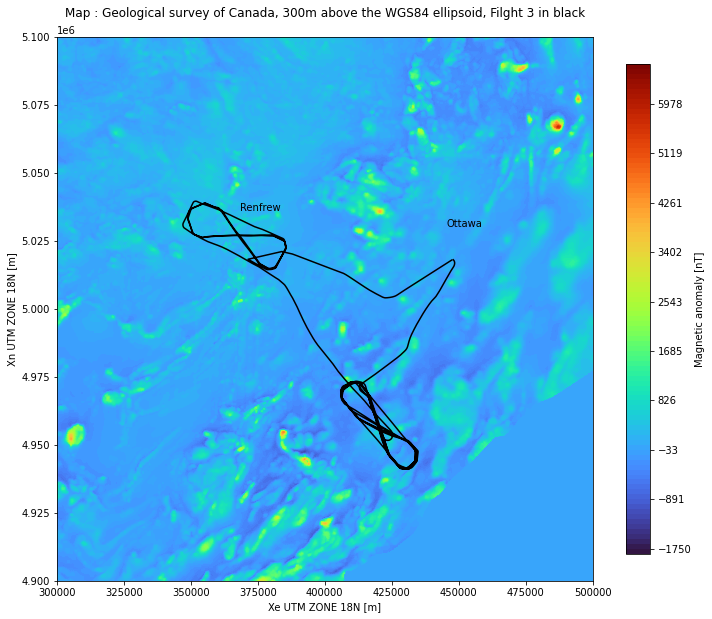

In [11]:
fig, ax = plt.subplots(figsize=[12,10])

df_sel_lines.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax)
ax = GscMap.plot(ax, plot_city=True)
ax.set_title(f'Map : Geological survey of Canada, {GscMap.alt}m above the WGS84 ellipsoid, Filght {w_flight.value} in black',pad=20);
ax.set_xlim(3e5, 5e5)
ax.set_ylim(4.90e6, 5.1e6)

plt.show()

### 2.3.3 - Challenge maps

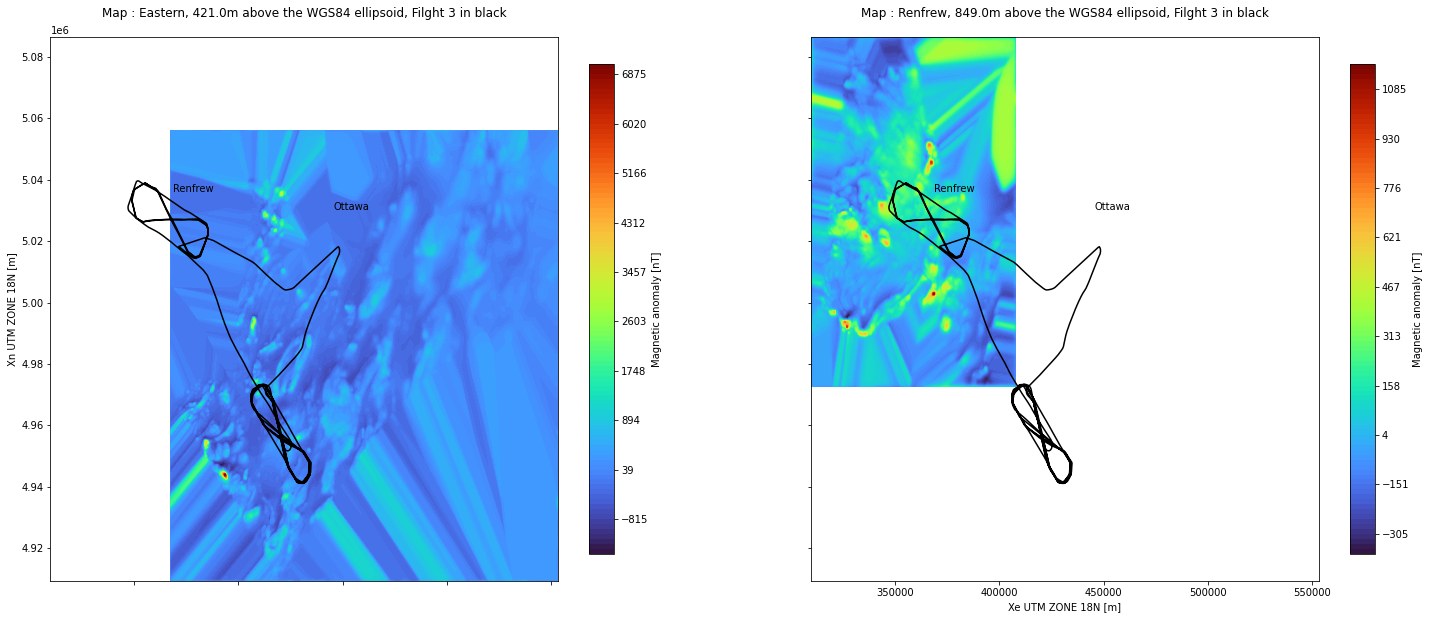

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=[25,10])

df_sel_lines.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax1)
ax1 = EasternMap.plot(ax1,plot_city=True)
ax1.set_title(f'Map : Eastern, {EasternMap.alt}m above the WGS84 ellipsoid, Filght {w_flight.value} in black',pad=20);

df_sel_lines.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax2)
ax2 = RenfrewMap.plot(ax2, plot_city=True)
ax2.set_title(f'Map : Renfrew, {RenfrewMap.alt}m above the WGS84 ellipsoid, Filght {w_flight.value} in black',pad=20);

plt.show()

### 2.3.4 - World Digital Magnetic Anomaly Map

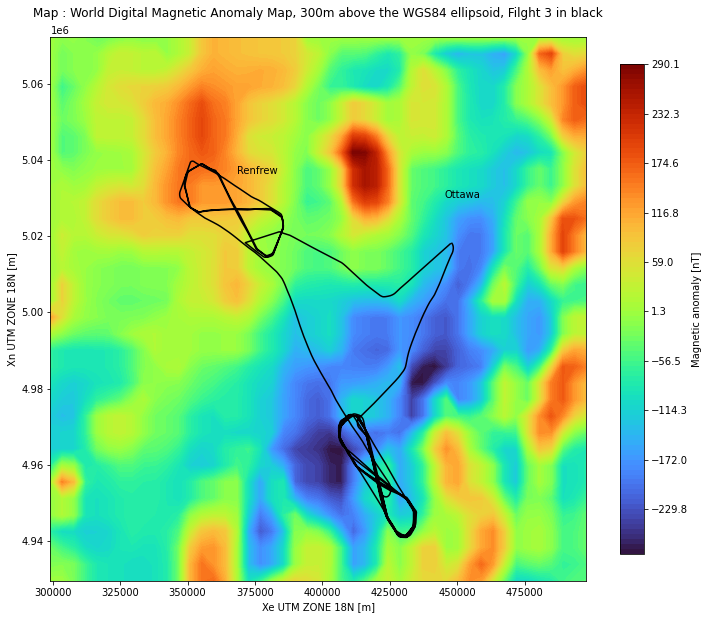

In [13]:
fig, ax = plt.subplots(figsize=[12,10])

df_sel_lines.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax)
ax = WDMAM.plot(ax, plot_city=True)
ax.set_title(f'Map : World Digital Magnetic Anomaly Map, {WDMAM.alt}m above the WGS84 ellipsoid, Filght {w_flight.value} in black',pad=20);

plt.show()

### 2.3.5 - Map resolutions

The goal is to compare the accuracy between anomaly maps and truth data and see the impact of map accuracy. In this dataset, we have the truth thanks to a magnetometer on a pole. However in most experiments this is not the case (same for navigation) and so the way to get truth is from magnetic anomaly maps.
We have 4 different maps available :
- Anomaly map of Canada (mid resolution)
- Anomaly map of Renfrew (high resolution)
- Anomaly map of Eastern Renfrew, south of Ottawa (high resolution)
- World Digital Magnetic Anomaly Map (low resolution)

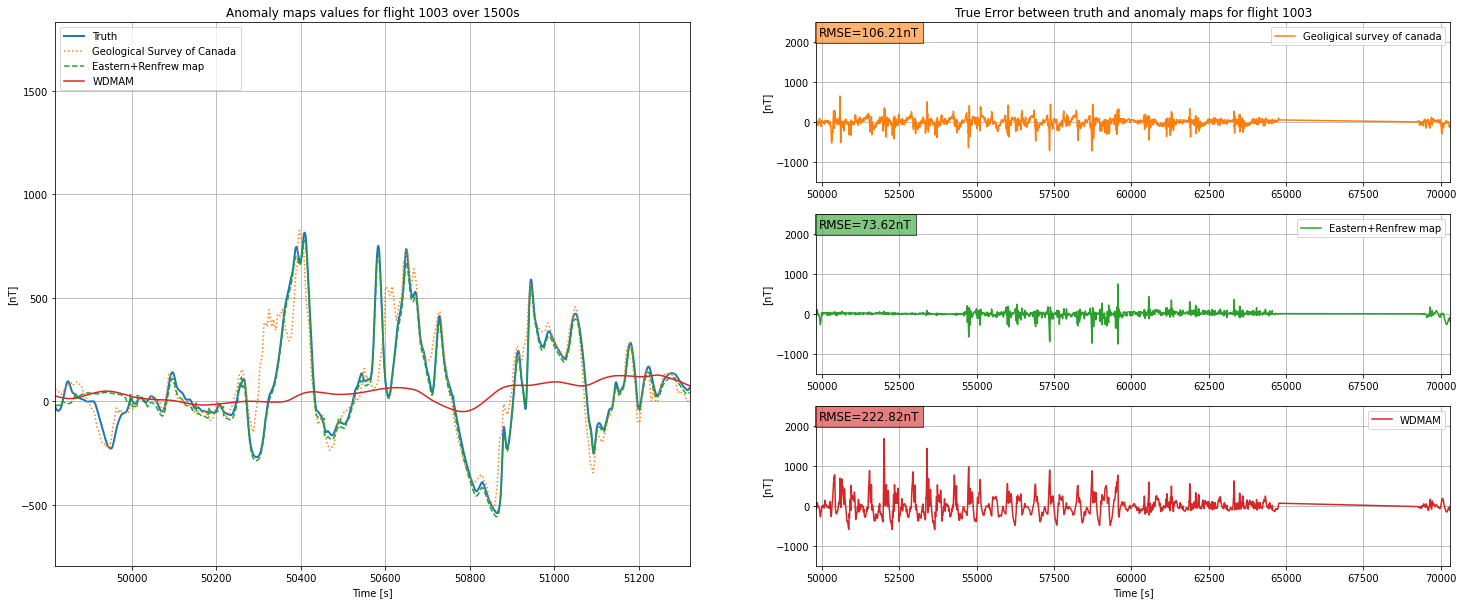

In [14]:
df_maps = pd.DataFrame()

# Interpolation of anomaly maps
df_maps['IGRFMAG1']    = copy.deepcopy(df_sel_flight['IGRFMAG1'])
df_maps['GSC_map']     = GscMap.interpolate(df_sel_flight.UTM_X, df_sel_flight.UTM_Y)
df_maps['Eastern_map'] = EasternMap.interpolate(df_sel_flight.UTM_X, df_sel_flight.UTM_Y)
df_maps['Renfrew_map'] = RenfrewMap.interpolate(df_sel_flight.UTM_X, df_sel_flight.UTM_Y)
df_maps['WDMAM_map']   = WDMAM.interpolate(df_sel_flight.UTM_X, df_sel_flight.UTM_Y)

# Remove linear trend
df_maps['IGRFMAG1']    = signal.detrend(df_maps['IGRFMAG1'])
df_maps['WDMAM_map']   = signal.detrend(df_maps['WDMAM_map'])
df_maps['Eastern_map'] = signal.detrend(df_maps['Eastern_map'])
df_maps['Renfrew_map'] = signal.detrend(df_maps['Renfrew_map'])
df_maps['GSC_map']     = signal.detrend(df_maps['GSC_map'])

# Calculate error between truth data and anomaly maps
GSC_map_error     = (df_maps['IGRFMAG1']-df_maps['GSC_map'])
Eastern_map_error = (df_maps['IGRFMAG1']-df_maps['Eastern_map'])
Renfrew_map_error = (df_maps['IGRFMAG1']-df_maps['Renfrew_map'])
WDMAM_map_error   = (df_maps['IGRFMAG1']-df_maps['WDMAM_map'])

# Calculate RMSE between truth data and anomaly maps
GSC_map_rmse      = magnav.rmse(df_maps['GSC_map'],df_maps['IGRFMAG1'])
WDMAM_map_rmse    = magnav.rmse(df_maps['WDMAM_map'],df_maps['IGRFMAG1'])

# Fusion of Eastern and Renfrew maps
East_Ren_map = df_maps['Eastern_map'].where(np.abs(Eastern_map_error)<np.abs(Renfrew_map_error))
df_maps['East_Ren_map'] = East_Ren_map.fillna(df_maps['Renfrew_map'])

East_Ren_map_error = (df_maps['IGRFMAG1']-df_maps['East_Ren_map'])
East_Ren_map_rmse = magnav.rmse(df_maps['East_Ren_map'],df_maps['IGRFMAG1'])

# Plot results
plt.figure(figsize=[25,10])
ax1 = plt.subplot(3,2,2)
ax2 = plt.subplot(3,2,4)
ax3 = plt.subplot(3,2,6)
ax4 = plt.subplot(1,2,1)

ax4.plot(df_maps['IGRFMAG1'],'C0',linewidth=2)
ax4.plot(df_maps['GSC_map'],'C1:')
ax4.plot(df_maps['East_Ren_map'],'C2--')
ax4.plot(df_maps['WDMAM_map'],'C3')

ax4.legend(['Truth','Geological Survey of Canada','Eastern+Renfrew map','WDMAM'],loc='upper left')
ax4.set_title(f'Anomaly maps values for flight 100{w_flight.value} over 1500s')
ax4.set_ylabel('[nT]'), ax4.set_xlabel('Time [s]')
ax4.axes.set_xlim(left=df_maps.index[0], right=df_maps.index[0]+1500)
ax4.grid()

ax1.plot(GSC_map_error,'C1'),ax2.plot(East_Ren_map_error,'C2'), ax3.plot(WDMAM_map_error,'C3')

# RMSE box
ax1.text(df_maps.index[0]+80,2150,f'RMSE={GSC_map_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C1',alpha=0.6))
ax2.text(df_maps.index[0]+80,2150,f'RMSE={East_Ren_map_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C2',alpha=0.6))
ax3.text(df_maps.index[0]+80,2150,f'RMSE={WDMAM_map_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C3',alpha=0.6))


ax1.set_title(f'True Error between truth and anomaly maps for flight 100{w_flight.value}')
ax1.set_ylabel('[nT]'), ax2.set_ylabel('[nT]'), ax3.set_ylabel('[nT]'), ax3.set_xlabel('Time [s]')
ax1.axes.set_ylim(bottom=-1500, top=2500), ax2.axes.set_ylim(bottom=-1500, top=2500), ax3.axes.set_ylim(bottom=-1500, top=2500)
ax1.axes.set_xlim(left=df_maps.index[0], right=df_maps.index[-1]), ax2.axes.set_xlim(left=df_maps.index[0], right=df_maps.index[-1]), ax3.axes.set_xlim(left=df_maps.index[0], right=df_maps.index[-1])
ax1.legend(['Geoligical survey of canada']), ax2.legend(['Eastern+Renfrew map']), ax3.legend(['WDMAM'])
ax1.grid(), ax2.grid(), ax3.grid()

plt.show()

<font size="4">Interpretation of results :</font><br>
As we can see higher resolution are closer from truth data than lower resolution maps. If we want to use maps as truth data to train a ML model we will need a high resolution map.

# 3 - Flight events

We have access to evenements that happened during the flight. These events can be used to highlight relationships between the environment or certain elements of the aircraft and the magnetic measurements.

## 3.1 - Events during the selected section(s)

In [15]:
line_df = pd.read_csv(f'../data/interim/readmes/Flight_100{w_flight.value}/Flt100{w_flight.value}-lines.csv')
coms_df = pd.read_csv(f'../data/interim/readmes/Flight_100{w_flight.value}/Flt100{w_flight.value}-comments.csv')

sel_lines_df = pd.DataFrame()
sel_coms_df  = pd.DataFrame()

for n in range(len(w_lines.value)):
    df_concat = line_df.loc[line_df['Line Number'] == w_lines.value[n]]
    sel_lines_df = pd.concat([sel_lines_df,df_concat])

print(sel_lines_df.to_string(index=False),'\n')

for n in range(len(w_lines.value)):
    df_concat = coms_df.loc[coms_df['Line Number'] == w_lines.value[n]]
    sel_coms_df = pd.concat([sel_coms_df,df_concat])

print(sel_coms_df.to_string(index=False))

del line_df, coms_df

 Start Time  End Time  Line Number                 Description
    49820.0   50713.0      1003.01  Takeoff - Eastern Free Fly
    50713.0   54497.0      1003.02       Eastern Free Fly 400m
    54497.0   54639.0      1003.03               Climb to 800m
    54639.0   59475.0      1003.04       Eastern Free Fly 800m
    59475.0   59926.0      1003.05             Transit at 800m
    59926.0   60105.0      1003.06             Descend to 400m
    60105.0   60243.0      1003.07 Transit to Renfrew Free-Fly
    60243.0   64586.0      1003.08       Renfrew Free Fly 400m
    64586.0   64763.0      1003.09               Climb to 800m
    69252.0   70311.0      1003.11             Transit to base 

    Time                         Parameter Message  Line Number
50255.97                          WX RADAR ON\\OFF      1003.01
50771.63                               IN BOX AREA      1003.02
50806.38                                POWER LINE      1003.02
50943.57                                POWER LIN

## 3.2 - Label creation for different events

In [16]:
# TODO : creation de label pour le training (Ex : si evenement avion alors 1 sir evenement sol alors 2 etc)

# 4 - Visualization of magnetic sensors position and direction

The magnetometers are the main elements of this project and for that it is important to know where they are placed in the aircraft. It is expected that the position plays a role on the magnetic field measurements as well as the elements located near the magnetometers. There are 2 types of magnetic sensors :
- 5 Scalar magnetometers ~ optically-pumped ,cesium split-beam named Mag 1/2/3/4/5
- 3 Vector fluxgate magnetometers ~ named Flux B/C/D

We have below a representation of their position in the plane as well as the possibility to vary the time to see the direction of the magnetic field measured by the vector magnetometers. The origin correspond to front seat rail.

In [17]:
def plot_mag(time):
    # Scalar magnetometers position
    Scal_mag = np.array([[-12.01,0,1.37],
                        [-0.60,-0.36,0],
                        [-1.28,-0.36,0],
                        [-3.53,0,0],
                        [-3.79,0,1.20]])

    # Vector magnetometers position
    Vect_mag = np.array([[-8.92,0,0.96],
                         [-4.06,0.42,0],
                         [-4.06,-0.42,0]])

    fig = plt.figure(figsize=[15,15])
    ax  = fig.add_subplot(projection='3d')

    # Plot scalar magnetometers position
    for n in range(5):
        ax.scatter(Scal_mag[n][0],Scal_mag[n][1],Scal_mag[n][2],color='red',marker='^')
        ax.text(Scal_mag[n][0],Scal_mag[n][1],Scal_mag[n][2],str(n+1))

    # Plot vector magnetometers position
    for n in range(3):
        name = ['B','C','D']
        ax.scatter(Vect_mag[n][0],Vect_mag[n][1],Vect_mag[n][2],color='blue',marker='*')
        ax.text(Vect_mag[n][0],Vect_mag[n][1],Vect_mag[n][2],name[n])

    # Origin
    ax.scatter(0,0,0,color='green',marker='x'), ax.text(0,0,0,'')

    # Origin arrows
    ax.quiver(0,0,0,1,0,0), ax.quiver(0,0,0,0,1,0), ax.quiver(0,0,0,0,0,1) # x,y,z arrow

    # Mag vectors direction
    scale_factor = 0.00004
    ax.quiver(-8.92,0,0.96,
              scale_factor*df_sel_flight.loc[time,'FLUXB_X'],
              scale_factor*df_sel_flight.loc[time,'FLUXB_Y'],
              scale_factor*df_sel_flight.loc[time,'FLUXB_Z'],color='green')
    ax.quiver(-4.06,0.42,0,
              scale_factor*df_sel_flight.loc[time,'FLUXC_X'],
              scale_factor*df_sel_flight.loc[time,'FLUXC_Y'],
              scale_factor*df_sel_flight.loc[time,'FLUXC_Z'],color='green')
    ax.quiver(-4.06,-0.42,0,
              scale_factor*df_sel_flight.loc[time,'FLUXD_X'],
              scale_factor*df_sel_flight.loc[time,'FLUXD_Y'],
              scale_factor*df_sel_flight.loc[time,'FLUXD_Z'],color='green')


    # Legend and labels
    ax.legend(['Mag 1 - Tail stinger', 'Mag 2 - Front cabin aft of cockpit', 'Mag 3 - Mid cabin aft of cockpit', 'Mag 4 - Rear cabin floor','Mag 5 - Rear cabin ceiling',
               'Flux B - Tail at base of stinger','Flux C - Rear cabin port side','Flux D - Rear cabin aft side',
               'Center - Front seat rail'])
    ax.set_xlabel('X [m]'), ax.set_ylabel('Y [m]'), ax.set_zlabel('Z [m]')

    # Axes limit
    ax.axes.set_xlim3d(left=-12.5, right=12.5), ax.axes.set_ylim3d(bottom=-12.5, top=12.5), ax.axes.set_zlim3d(bottom=-12.5, top=12.5)

    plt.show()

    # Plot image
    fig, ax = plt.subplots(figsize=[12,12])
    img = image.imread('../data/external/Images/plane.png')
    ax.imshow(img)

    # Remove axes
    ax.spines['bottom'].set_visible(False), ax.spines['top'].set_visible(False), ax.spines['left'].set_visible(False), ax.spines['right'].set_visible(False)
    ax.set_xticks([]) ,ax.set_yticks([])

    plt.show()

In [18]:
widgets.interact(plot_mag, time=(df_sel_flight.index[0],df_sel_flight.index[-1],0.1))

interactive(children=(FloatSlider(value=60065.5, description='time', max=70311.0, min=49820.0), Output()), _do…

<function __main__.plot_mag(time)>

<font size="4">Interpretation of results :</font><br>
As we can seen above, there seems to be a convention problem betweeen vector magnetometers.

In [19]:
#TODO correct flux B orientation

# 5 - Data correction

We have the raw measurements of the magnetometers and they need to go through corrections to get closer to the truth. For this purpose, there are several important corrections :
- Tolles Lawson correction
- Lag correction
- Diurnal correction
- IGRF correction

We will therefore study these different corrections and their impact on the data.

## 5.1 - Tolles Lawson

### 5.1.1 - What is Tolles Lawson ?

Tolles-Lawson uses measurements from a vector magnetometer to remove aircraft magnetic field contributions to the scalar magnetometer measurements, which are used for navigation. It is anticipated that the magnetic dynamics of an operational aircraft will exceed this model, but its assumptions are valid for compensation of the the stinger magnetometer. The Tolles-Lawson procedure considers the projection of the aircraft magnetic field onto the earth magnetic field, whereas a slightly modified version in Han_2017 considers the projection of the aircraft magnetic field onto the total field, which follows here

![coordinate_system](../data/external/Images/coordinate_system.JPG)

(a)Earth, aircraft, and total magnetic field vectors with projections of the aircraft and earth magnetic fields onto the total magnetic field. (b) Aircraft coordinate system centered on the front seat rail, where $x$ is positive in the aircraft forward direction, $y$ is positive to port (left facing forward), and $z$ is positive upward.

The total magnetic field vector $\mathbf H_t = \mathbf H_e + \mathbf H_a$ is comprised of the earth $\mathbf H_e$ and aircraft $\mathbf H_a$ fields. The reference frame is defined with respect to the transverse, longitudinal, and vertical axes of the aircraft, as shown in Figure. The aircraft magnetic field includes contributions from the permanent magnetic moment, induced magnetic moment, and eddy currents of the aircraft. Their contributions to the magnitude of the total field can be written as Eq.1 :
\begin{equation} \label{eq:H_at} H_{at} = \mathbf P \mathbf u_t + \mathbf u_t^T A \mathbf u_t + (\mathbf u_t^T)' \mathbf B \mathbf u_t \end{equation}

where the unit vector
\begin{equation} \mathbf u_t = \frac{\mathbf H_t}{H_t} = \begin{pmatrix} \cos X \\ \cos Y \\ \cos Z \\ \end{pmatrix} \end{equation}

is directly measured by the vector magnetometer, and consists of direction cosines defined by angles $X, Y, Z$ between the total field vector and the respective axes of the reference frame. The coefficient matrices for the permanent moment
\begin{equation} \mathbf P = \begin{pmatrix} p_1 & p_2 & p_3 \end{pmatrix} \end{equation}

induced moment
\begin{equation} \mathbf A = \begin{pmatrix} a_{11} & a_{12} & a_{13} \\ a_{21} & a_{22} & a_{23} \\ a_{31} & a_{32} & a_{33} \end{pmatrix} \end{equation}

and eddy current
\begin{equation} \mathbf B = \begin{pmatrix} b_{11} & b_{12} & b_{13} \\ b_{21} & b_{22} & b_{23} \\ b_{31} & b_{32} & b_{33} \end{pmatrix} \end{equation}

contributions comprise the unknown coefficients to learn during calibration.

Consider the physics underlying this construction. The permanent dipole moment and resulting magnetic field of the aircraft are static with respect to the coordinate system, with projections onto the total field defined by the direction cosines. From this, it can be seen that $\mathbf P$ is the magnetic field vector due to the permanent dipole, with components along the reference frame axes. Note that the numerical indices (1, 2, 3) coincide with the corresponding ($x$, $y$, $z$) axes.

The induced dipole moment can be thought of as resulting from three bars which can be magnetized along the $x$, $y$, and $z$ axes, with moments proportional to the earth magnetic field projection onto that axis, but not necessarily located on any axis. In general, each dipole will create a vector field at the origin. This means $\mathbf A$ has components $a_{ij}$, where $u_i a_{ij}$ gives the component of the induced field in the $j$ direction due to the moment pointing in the $i$ direction.

A similar argument holds for the geometry and projections of the eddy current fields comprising $\mathbf B$. The notable difference is that the eddy currents arise from changes in the magnetic flux through surfaces of the aircraft, which make their contribution proportional to the time derivative of the direction cosines $(\mathbf u_t^T)'$.

The quadratic form of the second term in Eq. 1 implies that $\mathbf A$ can be made symmetric, reducing the number of unknown coefficients for the induced dipole field from 9 to 6, resulting in 18 Tolles-Lawson coefficients. Additional constraints, such as the direction cosine identity $\cos^2 X + \cos^2 Y + \cos^2 Z = 1$ or assumptions about the surfaces of the aircraft, may further reduce the number of terms and coefficients used in the Tolles-Lawson model.

**Tolles-Lawson Calibration**

Here a linear model is built to determine the unknown Tolles-Lawson coefficients.

A row vector of measurements is
\begin{equation} \boldsymbol \delta = \begin{pmatrix} \{u_i\} & \{u_i u_j\} & \{u_i' u_j\}\end{pmatrix} \end{equation}

at a given time step, and a matrix of these is measurements is
\begin{equation} \boldsymbol \Delta = \begin{pmatrix} \boldsymbol \delta_1 \\ \vdots \\ \boldsymbol \delta_{N_t}\end{pmatrix} \end{equation}

where each row is one of the $N_t$ timesteps and each column is a term $\cos X$, $\cos Y$, etc. The column vector of coefficients is \begin{equation} \boldsymbol \theta = \begin{pmatrix} \{p_i\} & \{a_{ij}\} & \{b_{ij}\}\end{pmatrix} \end{equation}

Because the magnitude of the total field $H_t = H_{at} + H_{et}$ is the sum of the projections of the aircraft and earth magnetic field onto the total magnetic field, the $N_t \times 1$ column vector $\mathbf h_t$ of total field measurements $H_t$ from the scalar magnetometer can be expressed as (Eq. 2) \begin{equation} \label{eq:H_TL} \mathbf H = \boldsymbol \Delta \boldsymbol \theta + \mathbf H_{et} \end{equation}

where $\mathbf h_{et}$ is the column vector of $H_{et}$ at each timestep, which cannot be measured directly.

To decouple the aircraft field from the earth field, it is helpful to identify a band in which the frequency content of the aircraft dominates the signal. The calibration flight pattern is roughly a square or a cloverleaf, with roll, pitch and yaw maneuvers performed along each leg. It can be helpful to think of these maneuvers as injecting aircraft magnetic field content into a given band. The square pattern is repeated in opposite directions, and is flown at high altitude with as tight turns as possible. While the frequency band of interest for magnetic navigation is between 1 mHz and 1 Hz, a **band of 0.1 - 0.9 Hz is typically used for calibration**. Applying a bandpass filter both sides of Eq.2 gives 
\begin{equation}
    bpf(\mathbf H) = bpf(\boldsymbol \Delta) \boldsymbol \theta + bpf(\mathbf H_{et}).
\end{equation}
If the bandpass-filtered earth magnetic field projection is zero, i.e. $bpf(\mathbf H_{et}) = 0$, 
\begin{equation}
    \mathbf y = \mathbf D \boldsymbol \theta
\end{equation}
where $\mathbf y = bpf(\mathbf H_t)$ and $\mathbf D = bpf(\boldsymbol \Delta)$. 

### 5.1.2 - Patterns

To perform a Tolles LAwson type compensation, we need a flight pattern over a magnetic plain (with few disturbances) with high amplitude aircraft movements. This is to highlight the impact of the aircraft on the magnetic measurements and these data are then enetred into the model to serve as a reference for the correction. We have two pattern available :
- A square pattern
- A cloverleaf pattern

In [20]:
flight_number = 2
df_pattern    = pd.read_hdf('../data/interim/Flt_data.h5',key=f'Flt100{flight_number}')

mask_1 = (df_pattern.LINE == 1002.02)
mask_2 = (df_pattern.LINE == 1002.20)

tl_sq = df_pattern[mask_1] # Square Tolles-Lawson pattern
tl_cl = df_pattern[mask_2] # Cloverleaf Tolles-Lawson pattern

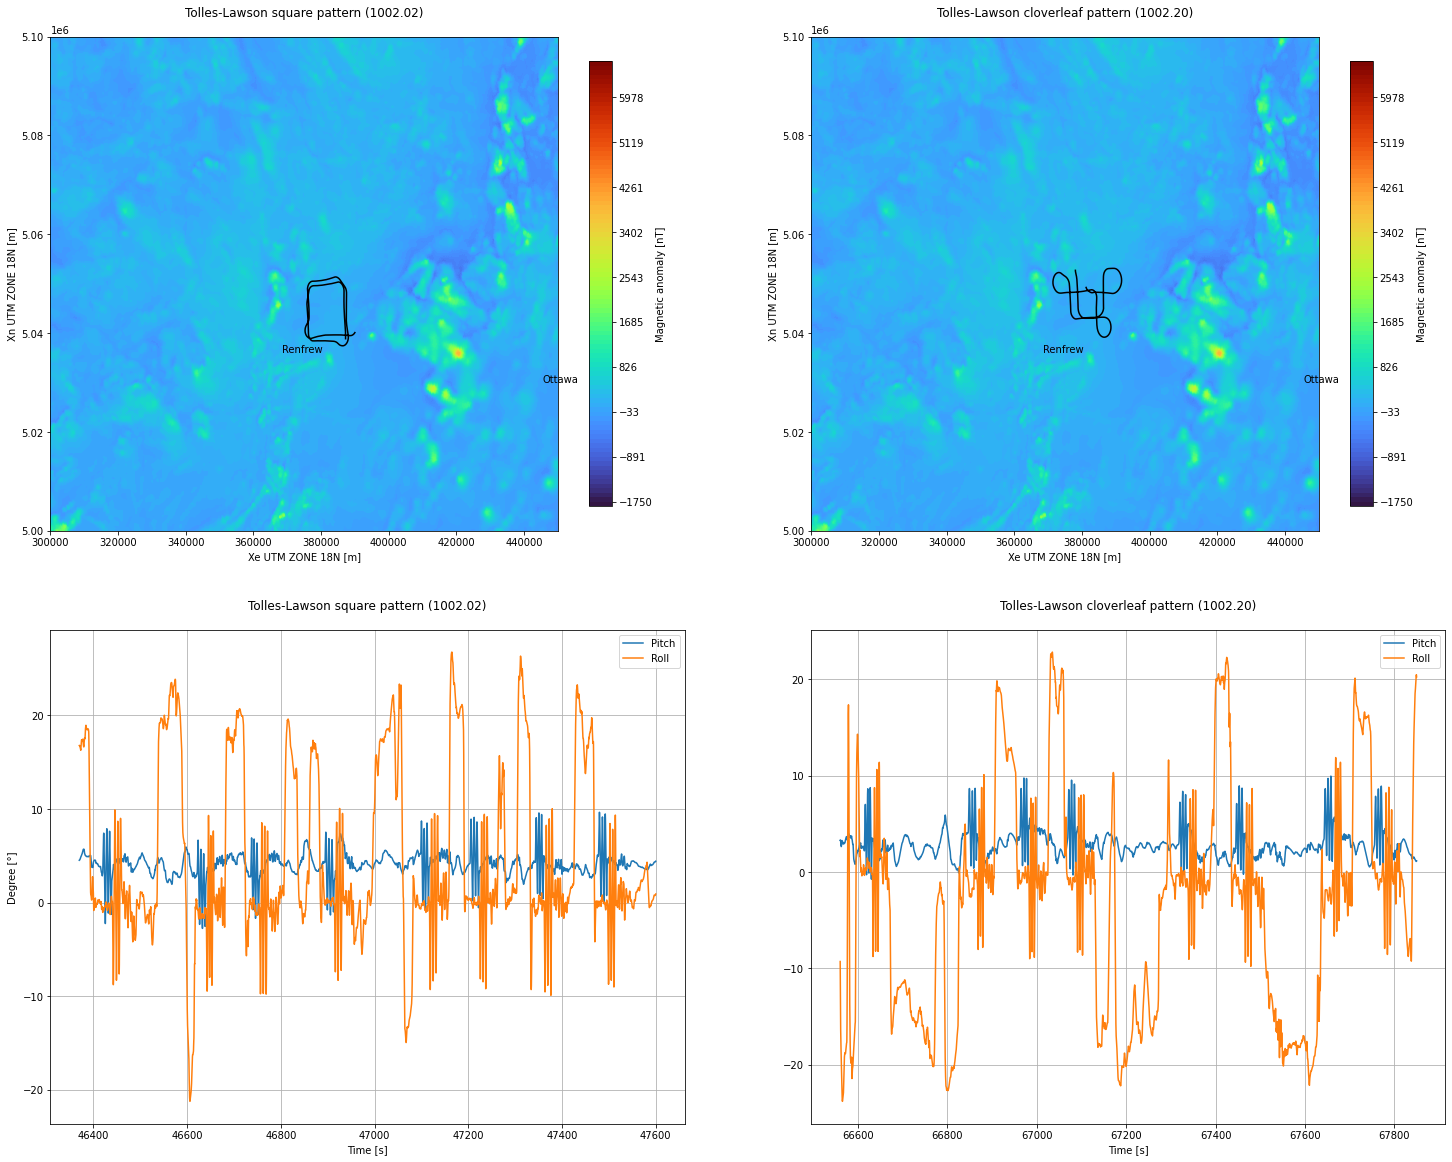

In [21]:
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2,sharex=False,sharey=False,figsize=[25,20])

tl_sq.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax1)
ax1 = GscMap.plot(ax1,plot_city=True)
ax1.set_title('Tolles-Lawson square pattern (1002.02)',pad=20);
ax1.set_xlim(3e5, 4.5e5)
ax1.set_ylim(5e6, 5.1e6);

tl_cl.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax2)
ax2 = GscMap.plot(ax2, plot_city=True)
ax2.set_title('Tolles-Lawson cloverleaf pattern (1002.20)',pad=20);
ax2.set_xlim(3e5, 4.5e5)
ax2.set_ylim(5e6, 5.1e6);

ax3.plot(tl_sq[['PITCH','ROLL']])
ax3.set_title('Tolles-Lawson square pattern (1002.02)',pad=20)
ax3.legend(['Pitch','Roll'])
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Degree [°]')
ax3.grid()

ax4.plot(tl_cl[['PITCH','ROLL']])
ax4.set_title('Tolles-Lawson cloverleaf pattern (1002.20)',pad=20)
ax4.legend(['Pitch','Roll'])
ax4.set_xlabel('Time [s]')
ax4.grid()

plt.show()

### 5.1.3 - Band pass filter

As said before, we use a bandpass filter to extract the frequency band where magnetic effects of the aircraft dominates the signal. In our case we use 2 types of filters, a Butterworth filter and a finit impulse response filter. The difference between the two filters on our data is almost insignificant.

low cut = 0.1 Hz, High cut = 0.9 Hz, sampling frequency = 10 Hz

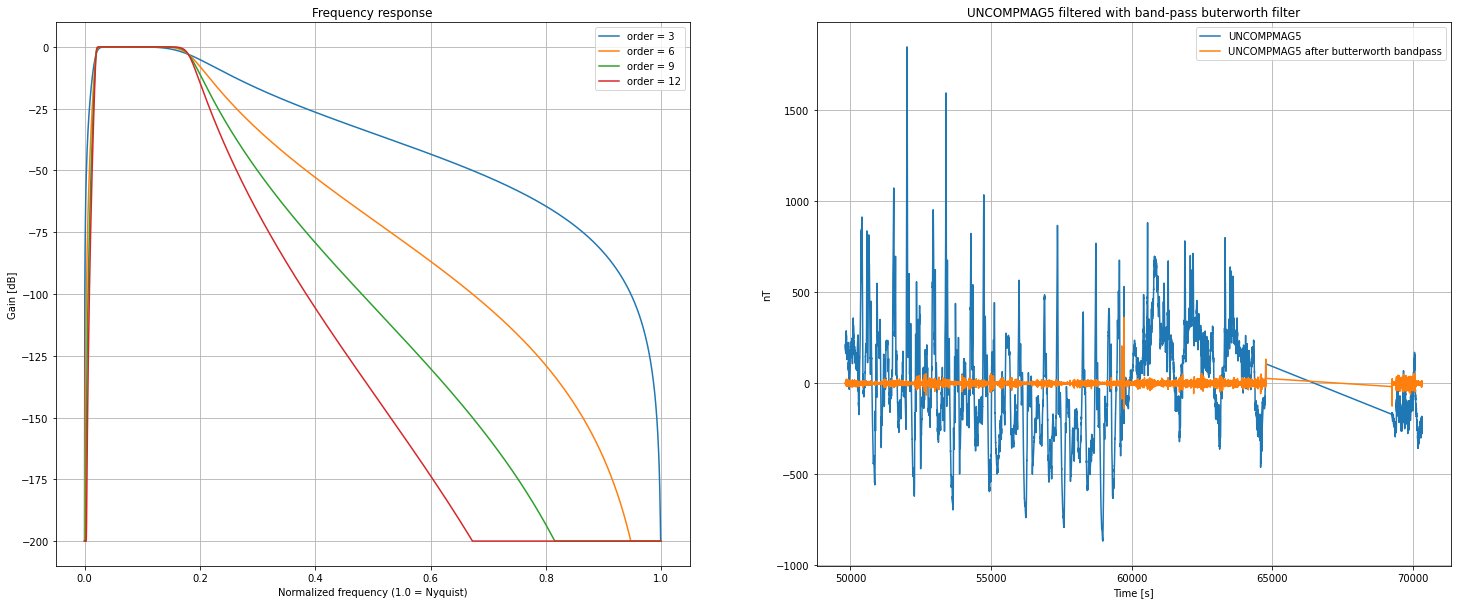

In [22]:
fs      = 10.0
lowcut  = 0.1
highcut = 0.9

fig, (ax1, ax2) = plt.subplots(1,2,sharex=False,sharey=False,figsize=[25,10])

for order in [3,6,9,12]:
    sos  = magnav.create_butter_filter(lowcut,highcut,fs,order=order)
    w, h = signal.sosfreqz(sos,worN=2000)
    db = 20*np.log10(np.maximum(np.abs(h),1e-10))
    ax1.plot(w/np.pi,db,label=f'order = {order}')
    
ax1.set_xlabel('Normalized frequency (1.0 = Nyquist)')
ax1.set_ylabel('Gain [dB]')
ax1.set_title('Frequency response')
ax1.legend()
ax1.grid()

sig = signal.detrend(np.array(df_sel_flight['UNCOMPMAG5']))
ax2.plot(df_sel_flight.index,sig,label='UNCOMPMAG5')

y = magnav.apply_butter_filter(sig,lowcut,highcut,fs,order=4)
ax2.plot(df_sel_flight.index,y,label='UNCOMPMAG5 after butterworth bandpass')

ax2.grid()
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('nT')
ax2.legend()
ax2.set_title('UNCOMPMAG5 filtered with band-pass buterworth filter')

plt.show()

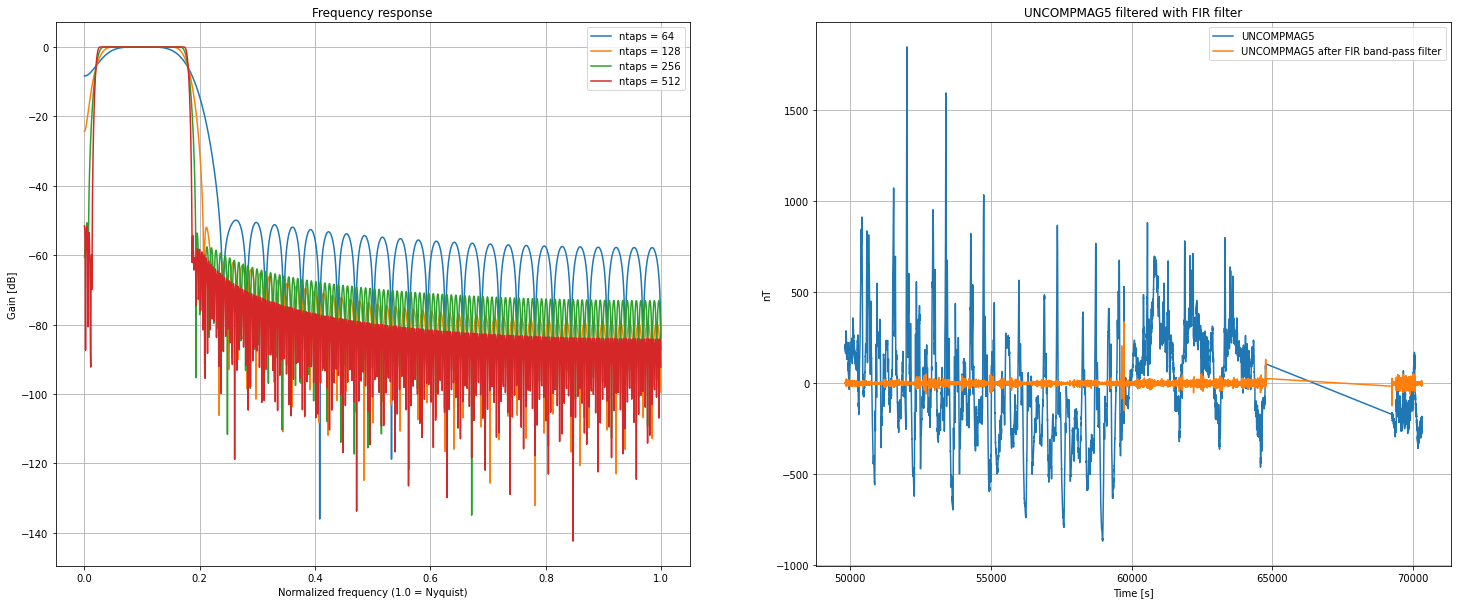

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2,sharex=False,sharey=False,figsize=[25,10])

for ntaps in [64,128,256,512]:
    taps_hamming = magnav.create_firwin_filter(lowcut,highcut,fs,ntaps)
    w, h = signal.freqz(taps_hamming,1,worN=2000)
    db = 20*np.log10(np.maximum(np.abs(h),1e-10))
    ax1.plot(w/np.pi,db,label=f'ntaps = {ntaps}')
    
ax1.set_xlabel('Normalized frequency (1.0 = Nyquist)')
ax1.set_ylabel('Gain [dB]')
ax1.set_title('Frequency response')
ax1.grid()
ax1.legend()

sig = signal.detrend(np.array(df_sel_flight['UNCOMPMAG5']))
ax2.plot(df_sel_flight.index,sig,label='UNCOMPMAG5')

y = magnav.apply_firwin_filter(sig,lowcut,highcut,fs,ntaps=255,window='hamming')
ax2.plot(df_sel_flight.index,y,label='UNCOMPMAG5 after FIR band-pass filter')
ax2.grid()
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('nT')
ax2.legend()
ax2.set_title('UNCOMPMAG5 filtered with FIR filter')

plt.show()

### 5.1.4 - Tolles Lawson coefficients | Square pattern

In the next cell, we compensate our scalar magnetometers using the Tolles Lawson method with a square pattern.

In [24]:
fs      = 10.0
lowcut  = 0.1
highcut = 0.9
filt    = ['Butterworth',4]

# Create Tolles-Lawson coefficients
TL_coef_1 = magnav.create_TL_coef(tl_sq['FLUXB_X'],tl_sq['FLUXB_Y'],tl_sq['FLUXB_Z'],tl_sq['UNCOMPMAG1'],
                                  lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_2 = magnav.create_TL_coef(tl_sq['FLUXB_X'],tl_sq['FLUXB_Y'],tl_sq['FLUXB_Z'],tl_sq['UNCOMPMAG2'],
                                  lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_3 = magnav.create_TL_coef(tl_sq['FLUXB_X'],tl_sq['FLUXB_Y'],tl_sq['FLUXB_Z'],tl_sq['UNCOMPMAG3'],
                                  lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_4 = magnav.create_TL_coef(tl_sq['FLUXB_X'],tl_sq['FLUXB_Y'],tl_sq['FLUXB_Z'],tl_sq['UNCOMPMAG4'],
                                  lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_5 = magnav.create_TL_coef(tl_sq['FLUXB_X'],tl_sq['FLUXB_Y'],tl_sq['FLUXB_Z'],tl_sq['UNCOMPMAG5'],
                                  lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)

# Create Tolles-Lawson A matrix
A = magnav.create_TL_A(df_sel_flight['FLUXB_X'],df_sel_flight['FLUXB_Y'],df_sel_flight['FLUXB_Z'])

# Correct magnetometers measurements
df_sel_flight['TL_comp_mag1_sq'] = np.reshape(df_sel_flight['UNCOMPMAG1'].tolist(),(-1,1))-np.dot(A,TL_coef_1)+np.mean(np.dot(A,TL_coef_1))
df_sel_flight['TL_comp_mag2_sq'] = np.reshape(df_sel_flight['UNCOMPMAG2'].tolist(),(-1,1))-np.dot(A,TL_coef_2)+np.mean(np.dot(A,TL_coef_2))
df_sel_flight['TL_comp_mag3_sq'] = np.reshape(df_sel_flight['UNCOMPMAG3'].tolist(),(-1,1))-np.dot(A,TL_coef_3)+np.mean(np.dot(A,TL_coef_3))
df_sel_flight['TL_comp_mag4_sq'] = np.reshape(df_sel_flight['UNCOMPMAG4'].tolist(),(-1,1))-np.dot(A,TL_coef_4)+np.mean(np.dot(A,TL_coef_4))
df_sel_flight['TL_comp_mag5_sq'] = np.reshape(df_sel_flight['UNCOMPMAG5'].tolist(),(-1,1))-np.dot(A,TL_coef_5)+np.mean(np.dot(A,TL_coef_5))

### 5.1.5 - Tolles Lawson coefficients | Cloverleaf pattern

In the next cell, we compensate our scalar magnetometers using the Tolles Lawson method with a cloverleaf pattern.

In [25]:
fs      = 10.0
lowcut  = 0.1
highcut = 0.9
filt    = ['Butterworth',4]

# Create Tolles-Lawson coefficients
TL_coef_1 = magnav.create_TL_coef(tl_cl['FLUXB_X'],tl_cl['FLUXB_Y'],tl_cl['FLUXB_Z'],tl_cl['UNCOMPMAG1'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_2 = magnav.create_TL_coef(tl_cl['FLUXB_X'],tl_cl['FLUXB_Y'],tl_cl['FLUXB_Z'],tl_cl['UNCOMPMAG2'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_3 = magnav.create_TL_coef(tl_cl['FLUXB_X'],tl_cl['FLUXB_Y'],tl_cl['FLUXB_Z'],tl_cl['UNCOMPMAG3'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_4 = magnav.create_TL_coef(tl_cl['FLUXB_X'],tl_cl['FLUXB_Y'],tl_cl['FLUXB_Z'],tl_cl['UNCOMPMAG4'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_5 = magnav.create_TL_coef(tl_cl['FLUXB_X'],tl_cl['FLUXB_Y'],tl_cl['FLUXB_Z'],tl_cl['UNCOMPMAG5'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)

# Create Tolles-Lawson A matrix
A = magnav.create_TL_A(df_sel_flight['FLUXB_X'],df_sel_flight['FLUXB_Y'],df_sel_flight['FLUXB_Z'])

# Correct magnetometers measurements
df_sel_flight['TL_comp_mag1_cl'] = np.reshape(df_sel_flight['UNCOMPMAG1'].tolist(),(-1,1))-np.dot(A,TL_coef_1)+np.mean(np.dot(A,TL_coef_1))
df_sel_flight['TL_comp_mag2_cl'] = np.reshape(df_sel_flight['UNCOMPMAG2'].tolist(),(-1,1))-np.dot(A,TL_coef_2)+np.mean(np.dot(A,TL_coef_2))
df_sel_flight['TL_comp_mag3_cl'] = np.reshape(df_sel_flight['UNCOMPMAG3'].tolist(),(-1,1))-np.dot(A,TL_coef_3)+np.mean(np.dot(A,TL_coef_3))
df_sel_flight['TL_comp_mag4_cl'] = np.reshape(df_sel_flight['UNCOMPMAG4'].tolist(),(-1,1))-np.dot(A,TL_coef_4)+np.mean(np.dot(A,TL_coef_4))
df_sel_flight['TL_comp_mag5_cl'] = np.reshape(df_sel_flight['UNCOMPMAG5'].tolist(),(-1,1))-np.dot(A,TL_coef_5)+np.mean(np.dot(A,TL_coef_5))

### 5.1.6 - Tolles Lawson coefficients | Square+Cloverleaf pattern

In the next cell, we compensate our scalar magnetometers using the Tolles Lawson method with a mix between square and cloverleaf pattern. This is an experimental test to see if we can take advantage of the two different patterns.

In [26]:
fs      = 10.0
lowcut  = 0.1
highcut = 0.9
filt    = ['Butterworth',4]

# Combine SQ and CL patterns
tl_sqcl = df_pattern[mask_1+mask_2]

# Create Tolles-Lawson coefficients
TL_coef_1 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'],tl_sqcl['FLUXB_Y'],tl_sqcl['FLUXB_Z'],tl_sqcl['UNCOMPMAG1'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_2 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'],tl_sqcl['FLUXB_Y'],tl_sqcl['FLUXB_Z'],tl_sqcl['UNCOMPMAG2'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_3 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'],tl_sqcl['FLUXB_Y'],tl_sqcl['FLUXB_Z'],tl_sqcl['UNCOMPMAG3'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_4 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'],tl_sqcl['FLUXB_Y'],tl_sqcl['FLUXB_Z'],tl_sqcl['UNCOMPMAG4'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_5 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'],tl_sqcl['FLUXB_Y'],tl_sqcl['FLUXB_Z'],tl_sqcl['UNCOMPMAG5'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)

# Create Tolles-Lawson A matrix
A = magnav.create_TL_A(df_sel_flight['FLUXB_X'],df_sel_flight['FLUXB_Y'],df_sel_flight['FLUXB_Z'])

# Correct magnetometers measurements
df_sel_flight['TL_comp_mag1_sqcl'] = np.reshape(df_sel_flight['UNCOMPMAG1'].tolist(),(-1,1))-np.dot(A,TL_coef_1)+np.mean(np.dot(A,TL_coef_1))
df_sel_flight['TL_comp_mag2_sqcl'] = np.reshape(df_sel_flight['UNCOMPMAG2'].tolist(),(-1,1))-np.dot(A,TL_coef_2)+np.mean(np.dot(A,TL_coef_2))
df_sel_flight['TL_comp_mag3_sqcl'] = np.reshape(df_sel_flight['UNCOMPMAG3'].tolist(),(-1,1))-np.dot(A,TL_coef_3)+np.mean(np.dot(A,TL_coef_3))
df_sel_flight['TL_comp_mag4_sqcl'] = np.reshape(df_sel_flight['UNCOMPMAG4'].tolist(),(-1,1))-np.dot(A,TL_coef_4)+np.mean(np.dot(A,TL_coef_4))
df_sel_flight['TL_comp_mag5_sqcl'] = np.reshape(df_sel_flight['UNCOMPMAG5'].tolist(),(-1,1))-np.dot(A,TL_coef_5)+np.mean(np.dot(A,TL_coef_5))

### 5.1.7 - Effect of various patterns

Mag 2 is not shown due to bad results (uncomment the lines below to show mag 2)

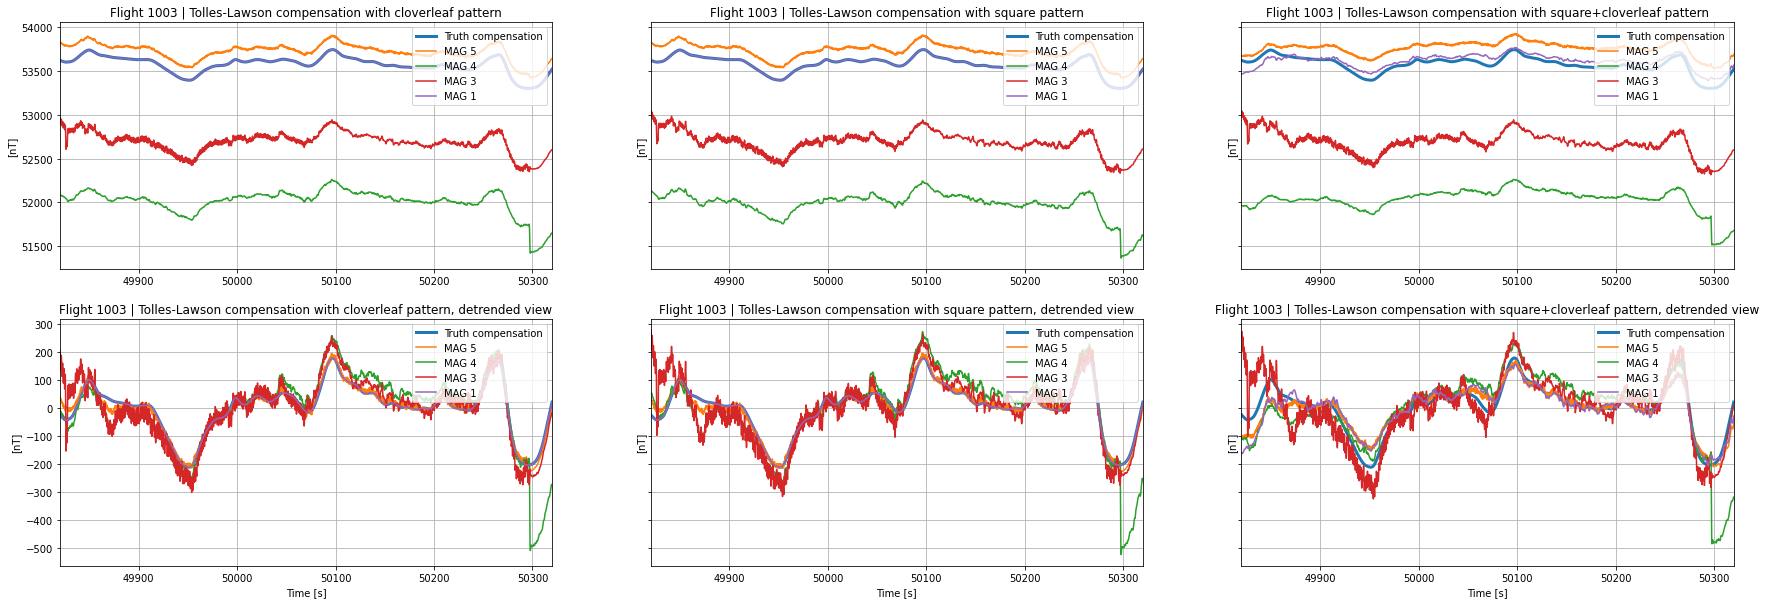

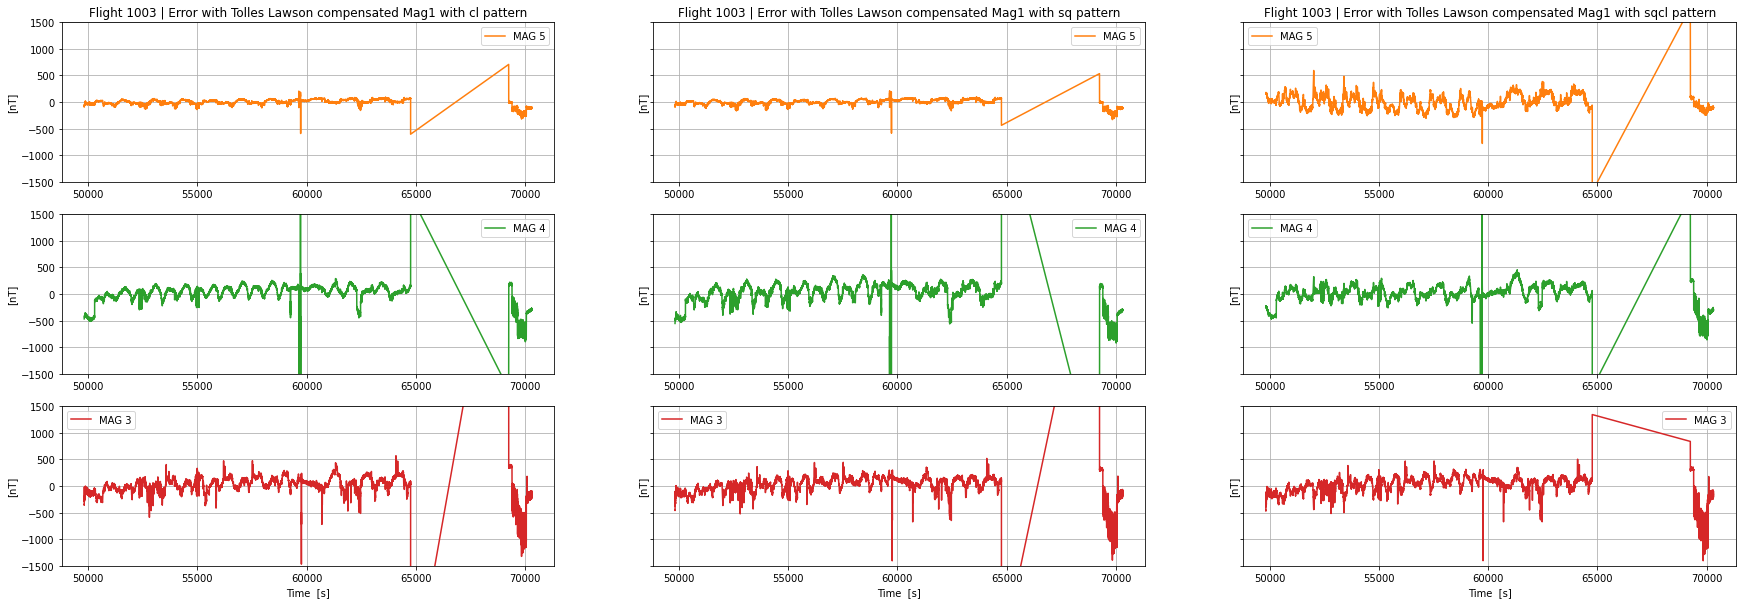


RMSE between Tolles Lowson compensated magnetometers and truth compensation (SGL COMPMAG1) :
╒════════════════╤════════════════════════════════╤════════════════════════════╤═══════════════════════════════════════╕
│   Magnetometer │   Cloverleaf compensation RMSE │   Square compensation RMSE │   Cloverleaf+Square compensation RMSE │
╞════════════════╪════════════════════════════════╪════════════════════════════╪═══════════════════════════════════════╡
│          Mag 1 │                        0.64 nT │                    0.50 nT │                             169.11 nT │
├────────────────┼────────────────────────────────┼────────────────────────────┼───────────────────────────────────────┤
│          Mag 2 │                    20883.40 nT │                15952.71 nT │                           15422.63 nT │
├────────────────┼────────────────────────────────┼────────────────────────────┼───────────────────────────────────────┤
│          Mag 3 │                      202.91 nT │        

In [27]:
fig, ([ax1,ax2,ax3],[ax4,ax5,ax6]) = plt.subplots(2,3,figsize=[30,10],sharey='row')

# Cloverleaf pattern
ax1.plot(df_sel_flight.index[:5000],df_sel_flight['COMPMAG1'][:df_sel_flight.index[0]+499.9],label='Truth compensation',linewidth=3)
ax1.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag5_cl'][:df_sel_flight.index[0]+499.9],label='MAG 5')
ax1.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag4_cl'][:df_sel_flight.index[0]+499.9],label='MAG 4')
ax1.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag3_cl'][:df_sel_flight.index[0]+499.9],label='MAG 3')
ax1.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag1_cl'][:df_sel_flight.index[0]+499.9],label='MAG 1')

ax1.axes.set_xlim(df_sel_flight.index[0],df_sel_flight.index[0]+500)
ax1.set_ylabel('[nT]')
ax1.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation with cloverleaf pattern')
ax1.legend(loc='upper right')
ax1.grid()

ax4.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['COMPMAG1'][:df_sel_flight.index[0]+499.9]),label='Truth compensation',linewidth=3)
ax4.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag5_cl'][:df_sel_flight.index[0]+499.9]),label='MAG 5')
ax4.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag4_cl'][:df_sel_flight.index[0]+499.9]),label='MAG 4')
ax4.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag3_cl'][:df_sel_flight.index[0]+499.9]),label='MAG 3')
ax4.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag1_cl'][:df_sel_flight.index[0]+499.9]),label='MAG 1')

ax4.axes.set_xlim(df_sel_flight.index[0],df_sel_flight.index[0]+500)
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('[nT]')
ax4.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation with cloverleaf pattern, detrended view')
ax4.legend(loc='upper right')
ax4.grid()

# Square pattern
ax2.plot(df_sel_flight.index[:5000],df_sel_flight['COMPMAG1'][:df_sel_flight.index[0]+499.9],label='Truth compensation',linewidth=3)
ax2.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag5_sq'][:df_sel_flight.index[0]+499.9],label='MAG 5')
ax2.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag4_sq'][:df_sel_flight.index[0]+499.9],label='MAG 4')
ax2.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag3_sq'][:df_sel_flight.index[0]+499.9],label='MAG 3')
ax2.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag1_sq'][:df_sel_flight.index[0]+499.9],label='MAG 1')

ax2.axes.set_xlim(df_sel_flight.index[0],df_sel_flight.index[0]+500)
ax2.set_ylabel('[nT]')
ax2.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation with square pattern')
ax2.legend(loc='upper right')
ax2.grid()

ax5.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['COMPMAG1'][:df_sel_flight.index[0]+499.9]),label='Truth compensation',linewidth=3)
ax5.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag5_sq'][:df_sel_flight.index[0]+499.9]),label='MAG 5')
ax5.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag4_sq'][:df_sel_flight.index[0]+499.9]),label='MAG 4')
ax5.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag3_sq'][:df_sel_flight.index[0]+499.9]),label='MAG 3')
ax5.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag1_sq'][:df_sel_flight.index[0]+499.9]),label='MAG 1')

ax5.axes.set_xlim(df_sel_flight.index[0],df_sel_flight.index[0]+500)
ax5.set_xlabel('Time [s]')
ax5.set_ylabel('[nT]')
ax5.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation with square pattern, detrended view')
ax5.legend(loc='upper right')
ax5.grid()

# Square+Cloverleaf pattern
ax3.plot(df_sel_flight.index[:5000],df_sel_flight['COMPMAG1'][:df_sel_flight.index[0]+499.9],label='Truth compensation',linewidth=3)
ax3.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag5_sqcl'][:df_sel_flight.index[0]+499.9],label='MAG 5')
ax3.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag4_sqcl'][:df_sel_flight.index[0]+499.9],label='MAG 4')
ax3.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag3_sqcl'][:df_sel_flight.index[0]+499.9],label='MAG 3')
ax3.plot(df_sel_flight.index[:5000],df_sel_flight['TL_comp_mag1_sqcl'][:df_sel_flight.index[0]+499.9],label='MAG 1')

ax3.axes.set_xlim(df_sel_flight.index[0],df_sel_flight.index[0]+500)
ax3.set_ylabel('[nT]')
ax3.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation with square+cloverleaf pattern')
ax3.legend(loc='upper right')
ax3.grid()

ax6.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['COMPMAG1'][:df_sel_flight.index[0]+499.9]),label='Truth compensation',linewidth=3)
ax6.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag5_sqcl'][:df_sel_flight.index[0]+499.9]),label='MAG 5')
ax6.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag4_sqcl'][:df_sel_flight.index[0]+499.9]),label='MAG 4')
ax6.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag3_sqcl'][:df_sel_flight.index[0]+499.9]),label='MAG 3')
ax6.plot(df_sel_flight.index[:5000],signal.detrend(df_sel_flight['TL_comp_mag1_sqcl'][:df_sel_flight.index[0]+499.9]),label='MAG 1')

ax6.axes.set_xlim(df_sel_flight.index[0],df_sel_flight.index[0]+500)
ax6.set_xlabel('Time [s]')
ax6.set_ylabel('[nT]')
ax6.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation with square+cloverleaf pattern, detrended view')
ax6.legend(loc='upper right')
ax6.grid()

plt.show()

fig, ([ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9]) = plt.subplots(3,3,figsize=[30,10],sharey=True)

ax1.plot(df_sel_flight.index,signal.detrend(df_sel_flight['COMPMAG1']-signal.detrend(df_sel_flight['TL_comp_mag5_cl'])),'C1',label='MAG 5')
ax4.plot(df_sel_flight.index,signal.detrend(df_sel_flight['COMPMAG1']-signal.detrend(df_sel_flight['TL_comp_mag4_cl'])),'C2',label='MAG 4')
ax7.plot(df_sel_flight.index,signal.detrend(df_sel_flight['COMPMAG1']-signal.detrend(df_sel_flight['TL_comp_mag3_cl'])),'C3',label='MAG 3')

ax2.plot(df_sel_flight.index,signal.detrend(df_sel_flight['COMPMAG1']-signal.detrend(df_sel_flight['TL_comp_mag5_sq'])),'C1',label='MAG 5')
ax5.plot(df_sel_flight.index,signal.detrend(df_sel_flight['COMPMAG1']-signal.detrend(df_sel_flight['TL_comp_mag4_sq'])),'C2',label='MAG 4')
ax8.plot(df_sel_flight.index,signal.detrend(df_sel_flight['COMPMAG1']-signal.detrend(df_sel_flight['TL_comp_mag3_sq'])),'C3',label='MAG 3')

ax3.plot(df_sel_flight.index,signal.detrend(df_sel_flight['COMPMAG1']-signal.detrend(df_sel_flight['TL_comp_mag5_sqcl'])),'C1',label='MAG 5')
ax6.plot(df_sel_flight.index,signal.detrend(df_sel_flight['COMPMAG1']-signal.detrend(df_sel_flight['TL_comp_mag4_sqcl'])),'C2',label='MAG 4')
ax9.plot(df_sel_flight.index,signal.detrend(df_sel_flight['COMPMAG1']-signal.detrend(df_sel_flight['TL_comp_mag3_sqcl'])),'C3',label='MAG 3')

ax1.set_ylim([-1500,1500])
ax1.grid(),ax2.grid(),ax3.grid(),ax4.grid(),ax5.grid(),ax6.grid(),ax7.grid(),ax8.grid(),ax9.grid()
ax1.legend(),ax2.legend(),ax3.legend(),ax4.legend(),ax5.legend(),ax6.legend(),ax7.legend(),ax8.legend(),ax9.legend()
ax7.set_xlabel('Time  [s]'),ax8.set_xlabel('Time  [s]'),ax9.set_xlabel('Time  [s]')
ax1.set_ylabel('[nT]'),ax2.set_ylabel('[nT]'),ax3.set_ylabel('[nT]'),ax4.set_ylabel('[nT]'),ax5.set_ylabel('[nT]'),ax6.set_ylabel('[nT]'),ax7.set_ylabel('[nT]'),ax8.set_ylabel('[nT]'),ax9.set_ylabel('[nT]')
ax1.set_title(f'Flight 100{w_flight.value} | Error with Tolles Lawson compensated Mag1 with cl pattern')
ax2.set_title(f'Flight 100{w_flight.value} | Error with Tolles Lawson compensated Mag1 with sq pattern')
ax3.set_title(f'Flight 100{w_flight.value} | Error with Tolles Lawson compensated Mag1 with sqcl pattern')
plt.show()


RMSE_mag1_sq = magnav.rmse(df_sel_flight['TL_comp_mag1_sq'],df_sel_flight['COMPMAG1'])
RMSE_mag2_sq = magnav.rmse(df_sel_flight['TL_comp_mag2_sq'],df_sel_flight['COMPMAG1'])
RMSE_mag3_sq = magnav.rmse(df_sel_flight['TL_comp_mag3_sq'],df_sel_flight['COMPMAG1'])
RMSE_mag4_sq = magnav.rmse(df_sel_flight['TL_comp_mag4_sq'],df_sel_flight['COMPMAG1'])
RMSE_mag5_sq = magnav.rmse(df_sel_flight['TL_comp_mag5_sq'],df_sel_flight['COMPMAG1'])

RMSE_mag1_cl = magnav.rmse(df_sel_flight['TL_comp_mag1_cl'],df_sel_flight['COMPMAG1'])
RMSE_mag2_cl = magnav.rmse(df_sel_flight['TL_comp_mag2_cl'],df_sel_flight['COMPMAG1'])
RMSE_mag3_cl = magnav.rmse(df_sel_flight['TL_comp_mag3_cl'],df_sel_flight['COMPMAG1'])
RMSE_mag4_cl = magnav.rmse(df_sel_flight['TL_comp_mag4_cl'],df_sel_flight['COMPMAG1'])
RMSE_mag5_cl = magnav.rmse(df_sel_flight['TL_comp_mag5_cl'],df_sel_flight['COMPMAG1'])

RMSE_mag1_sqcl = magnav.rmse(df_sel_flight['TL_comp_mag1_sqcl'],df_sel_flight['COMPMAG1'])
RMSE_mag2_sqcl = magnav.rmse(df_sel_flight['TL_comp_mag2_sqcl'],df_sel_flight['COMPMAG1'])
RMSE_mag3_sqcl = magnav.rmse(df_sel_flight['TL_comp_mag3_sqcl'],df_sel_flight['COMPMAG1'])
RMSE_mag4_sqcl = magnav.rmse(df_sel_flight['TL_comp_mag4_sqcl'],df_sel_flight['COMPMAG1'])
RMSE_mag5_sqcl = magnav.rmse(df_sel_flight['TL_comp_mag5_sqcl'],df_sel_flight['COMPMAG1'])

table = [['Magnetometer','Cloverleaf compensation RMSE','Square compensation RMSE','Cloverleaf+Square compensation RMSE'],
         ['Mag 1',f'{RMSE_mag1_cl:.2f} nT',f'{RMSE_mag1_sq:.2f} nT',f'{RMSE_mag1_sqcl:.2f} nT'],
         ['Mag 2',f'{RMSE_mag2_cl:.2f} nT',f'{RMSE_mag2_sq:.2f} nT',f'{RMSE_mag2_sqcl:.2f} nT'],
         ['Mag 3',f'{RMSE_mag3_cl:.2f} nT',f'{RMSE_mag3_sq:.2f} nT',f'{RMSE_mag3_sqcl:.2f} nT'],
         ['Mag 4',f'{RMSE_mag4_cl:.2f} nT',f'{RMSE_mag4_sq:.2f} nT',f'{RMSE_mag4_sqcl:.2f} nT'],
         ['Mag 5',f'{RMSE_mag5_cl:.2f} nT',f'{RMSE_mag5_sq:.2f} nT',f'{RMSE_mag5_sqcl:.2f} nT']]

print('\nRMSE between Tolles Lowson compensated magnetometers and truth compensation (SGL COMPMAG1) :')
print(tabulate(table,headers='firstrow',tablefmt='fancy_grid',stralign='right'))

<font size="4">Interpretation of results :</font><br> <a class="anchor" id = "explication"></a>
The magnetometer compensation matches the compensation made by SGL which corresponds to the truth (as can be seen for the magnetometer 1). However these data do not yet correspond to the magnetic anomaly measurements (truth in our case). For this we still have some corrections to make. We can also see that the compensation with the mix of the two patterns is not very good except for the magnetometer 4. The magnetometer 2 has very bad results. Magnetometer 5 is close to magnetometer 1. We also ahev the visualization of the error between the magnetometers and the truth, we see on this one that the error seems to be cyclic in the case of flight 1003. This is due to the overlapping pattern of the flight. We also observe a peak of error around 59700 seconds for flight 1003. This peak is due to a change in topology, and as SGL has smoothed its sensor, we get an error peak at this location. You can see it below in the topography of the flight.

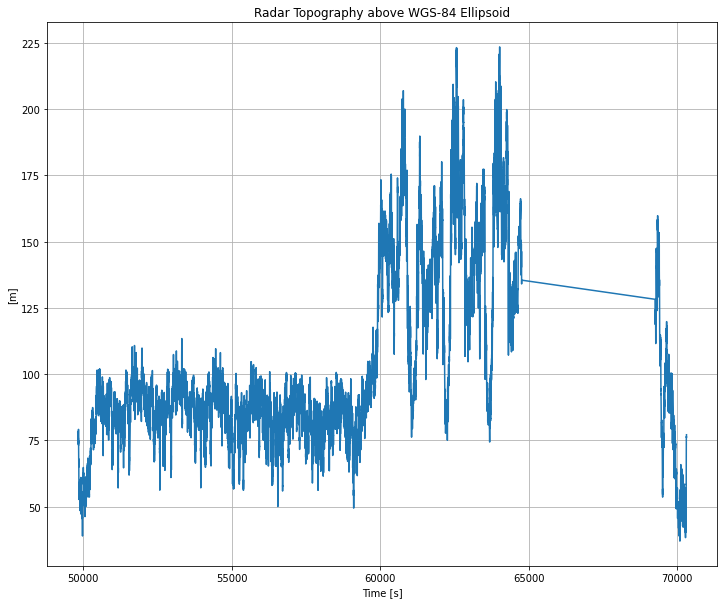

In [28]:
fig, ax = plt.subplots(figsize=[12,10])
ax.plot(df_sel_flight['TOPO'])
ax.grid(),ax.set_title('Radar Topography above WGS-84 Ellipsoid'),ax.set_ylabel('[m]'),ax.set_xlabel('Time [s]')
plt.show()

## 5.2 - Lag correction

The lag is the response of a measuring instrument to a change in the measured quantity. It is a retardation delay in the response of a measurement system to changes in the measured quantity. In our case, we can calculate the lag as follows :<br><br>
<font size="3">
    $Lag = \frac{sensor\;offset}{aircraft\;speed}$
</font><br><br>
sensor offset  : distance between reference point (front seat rail) and the sensor in meters<br>
aircraft speed : speed of the aircraft at which the measurement was made in meters per second<br>

In our case we can approximate the lag over the whole flight because the speed of the aircraft is almost constant.

In [29]:
Lag_mag1 = 12.01/np.mean(df_sel_flight['TRUE_AS'])
Lag_mag2 = 0.60/np.mean(df_sel_flight['TRUE_AS'])
Lag_mag3 = 1.28/np.mean(df_sel_flight['TRUE_AS'])
Lag_mag4 = 3.53/np.mean(df_sel_flight['TRUE_AS'])
Lag_mag5 = 3.79/np.mean(df_sel_flight['TRUE_AS'])

table = [['Magnetometer','Lag'],
         ['Mag 1',f'{Lag_mag1:.2f} s'],
         ['Mag 2',f'{Lag_mag2:.2f} s'],
         ['Mag 3',f'{Lag_mag3:.2f} s'],
         ['Mag 4',f'{Lag_mag4:.2f} s'],
         ['Mag 5',f'{Lag_mag5:.2f} s']]

print(tabulate(table,headers='firstrow',tablefmt='fancy_grid',stralign='center'))

╒════════════════╤════════╕
│  Magnetometer  │  Lag   │
╞════════════════╪════════╡
│     Mag 1      │ 0.18 s │
├────────────────┼────────┤
│     Mag 2      │ 0.01 s │
├────────────────┼────────┤
│     Mag 3      │ 0.02 s │
├────────────────┼────────┤
│     Mag 4      │ 0.05 s │
├────────────────┼────────┤
│     Mag 5      │ 0.06 s │
╘════════════════╧════════╛


<font size="4">Interpretation of results :</font><br>
Only the magnetometer 1 has a significant lag and is the only one we can correct by rounding the lag to 0,2s. If we want to be able to correct the other magnetometers, we need a higher sampling frequency of about 100Hz.

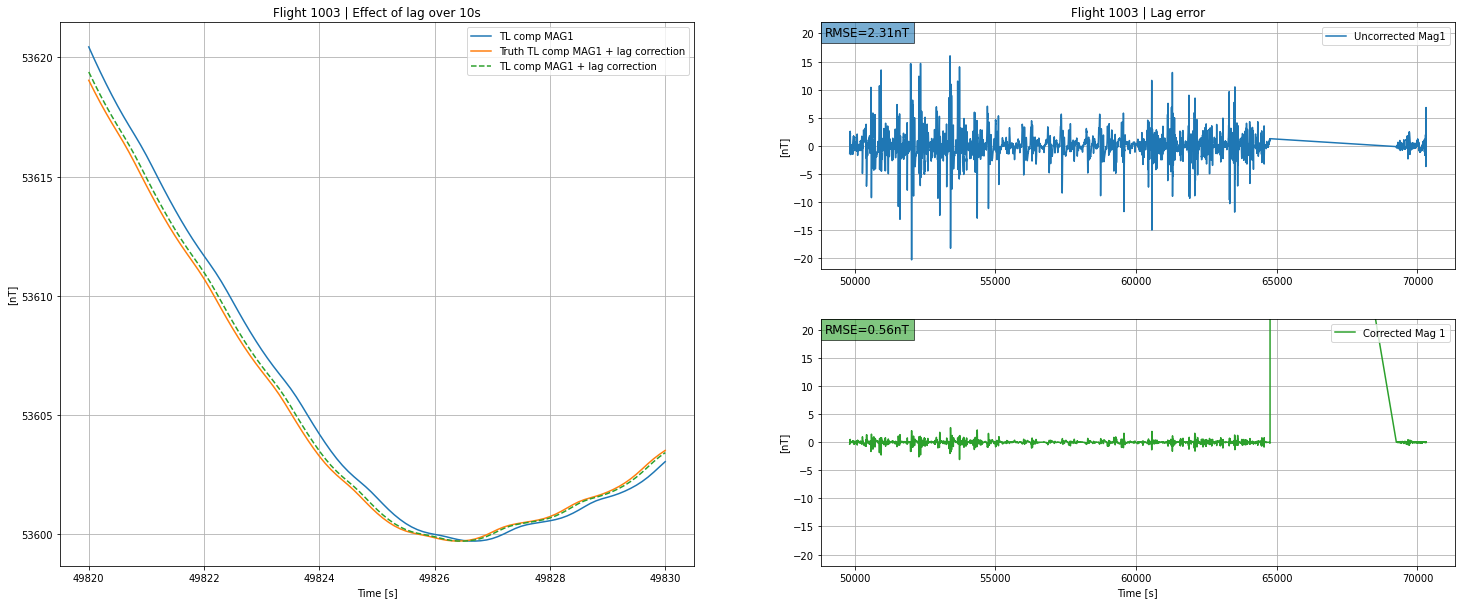

In [30]:
our_lag_cor       = df_sel_flight['COMPMAG1'].drop([df_sel_flight.index[0],df_sel_flight.index[1]])
our_lag_cor.index = df_sel_flight.index[:-2]
UNLAG_df = df_sel_flight.drop([df_sel_flight.index[-1],df_sel_flight.index[-2]])

plt.figure(figsize=[25,10])
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,4)

ax1.plot(UNLAG_df[['COMPMAG1','LAGMAG1']][:df_sel_flight.index[0]+10])
ax1.plot(our_lag_cor[:df_sel_flight.index[0]+10],'--')
ax1.legend(['TL comp MAG1','Truth TL comp MAG1 + lag correction','TL comp MAG1 + lag correction'])
ax1.set_title(f'Flight 100{w_flight.value} | Effect of lag over 10s')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('[nT]')
ax1.grid()

ax2.plot(UNLAG_df['LAGMAG1']-UNLAG_df['COMPMAG1'],'C0')
ax2.legend(['Uncorrected Mag1'])
ax2.set_title(f'Flight 100{w_flight.value} | Lag error')
ax2.set_ylabel('[nT]')
ax2.axes.set_ylim(-22,22)
ax2.grid()

lag_rmse = magnav.rmse(UNLAG_df['COMPMAG1'],UNLAG_df['LAGMAG1'])
ax2.text(df_sel_flight.index[0]-870,19.5,f'RMSE={lag_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C0',alpha=0.6))

ax3.plot(UNLAG_df['LAGMAG1']-our_lag_cor,'C2')
ax3.legend(['Corrected Mag 1'],loc='upper right')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('[nT]')
ax3.axes.set_ylim(-22,22)
ax3.grid()

unlag_rmse = magnav.rmse(our_lag_cor,UNLAG_df['LAGMAG1'])
ax3.text(df_sel_flight.index[0]-870,19.5,f'RMSE={unlag_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C2',alpha=0.6))

plt.show()

<font size="4">Interpretation of results :</font><br>
There is still a little error due to lag approximation. Also the truth lag correction was done with a professional software. Lag correction is not constant because it depends on aircraft speed and we assume that its constant but its not. The error is still small enough not to be considered as significant for the future.

## 5.3 - Diurnal correction

Also called **Solar Quiet currents (SQs)**, the diurnal effects correspond to the different weather variations. This comes mainly from the ionization of the ionosphere by the sun creating a slight variation in ambient magnetic intensity. This includes different effects such as :
- Day and night cycle
- Aurora Borealis
- Solar stoms

These effects are measured by ground stations and thanks to these measurements, we can remove these effects from the data of the magnetometer.

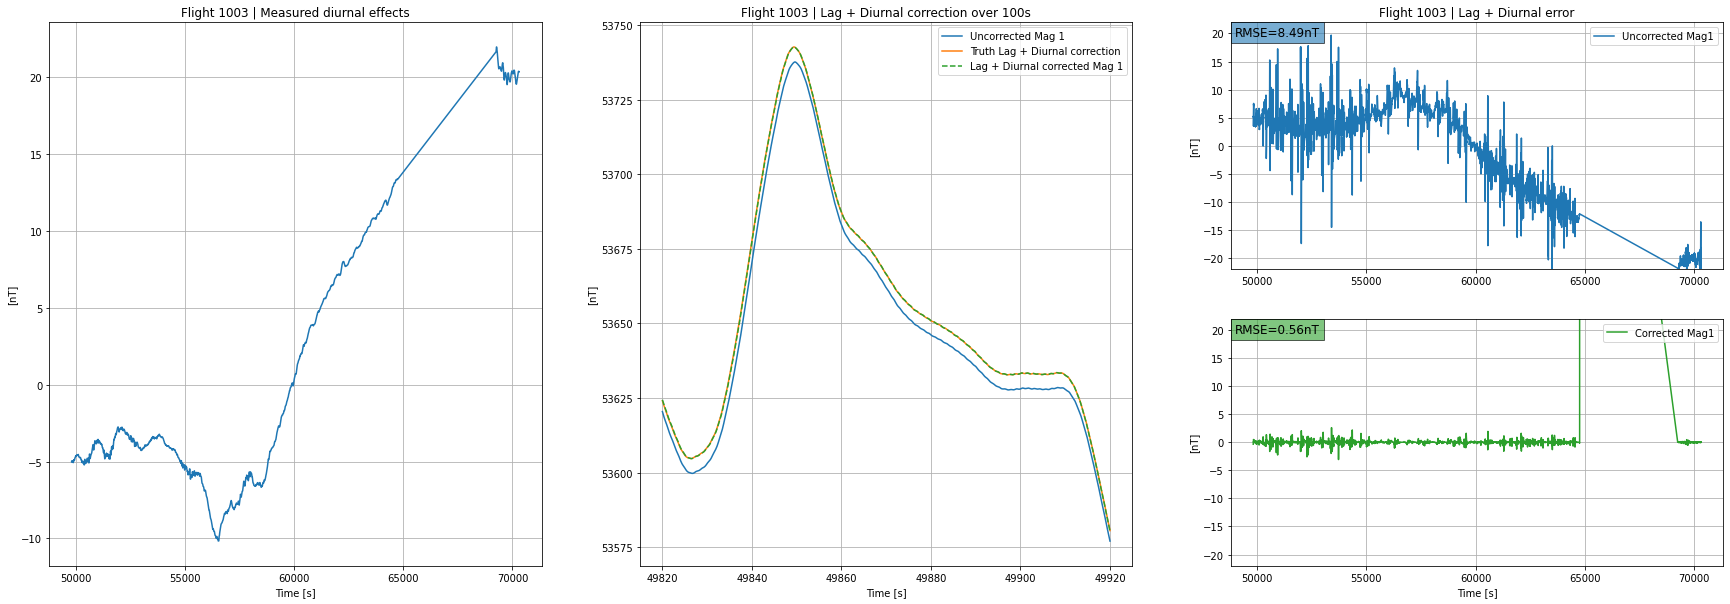

In [31]:
plt.figure(figsize=[30,10])
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,6)

# Diurnal plot
ax1.plot(df_sel_flight['DIURNAL'])
ax1.set_title(f'Flight 100{w_flight.value} | Measured diurnal effects')
ax1.set_ylabel('[nT]')
ax1.set_xlabel('Time [s]')
ax1.grid()

# Diurnal correction
our_dc_cor = our_lag_cor-UNLAG_df['DIURNAL']

ax2.plot(UNLAG_df[['COMPMAG1','DCMAG1']].loc[:df_sel_flight.index[0]+100])
ax2.plot(our_dc_cor.loc[:df_sel_flight.index[0]+100],'--')
ax2.legend(['Uncorrected Mag 1','Truth Lag + Diurnal correction','Lag + Diurnal corrected Mag 1'])
ax2.set_title(f'Flight 100{w_flight.value} | Lag + Diurnal correction over 100s')
ax2.set_ylabel('[nT]')
ax2.set_xlabel('Time [s]')
ax2.grid()

# Diurnal errors
uncor_rmse = magnav.rmse(UNLAG_df['COMPMAG1'],UNLAG_df['DCMAG1'])

ax3.plot(UNLAG_df['DCMAG1']-UNLAG_df['COMPMAG1'],'C0')
ax3.grid()
ax3.set_ylabel('[nT]')
ax3.set_title(f'Flight 100{w_flight.value} | Lag + Diurnal error')
ax3.axes.set_ylim(-22,22)
ax3.legend(['Uncorrected Mag1'],loc='upper right')
ax3.text(df_sel_flight.index[0]-830,19.5,f'RMSE={uncor_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C0',alpha=0.6))


cor_rmse = magnav.rmse(our_dc_cor,UNLAG_df['DCMAG1'])

ax4.plot(df_sel_flight['DCMAG1']-our_dc_cor,'C2')
ax4.grid()
ax4.set_ylabel('[nT]')
ax4.set_xlabel('Time [s]')
ax4.axes.set_ylim(-22,22)
ax4.legend(['Corrected Mag1'],loc='upper right')
ax4.text(df_sel_flight.index[0]-830,19.5,f'RMSE={cor_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C2',alpha=0.6))

plt.show()

<font size="4">Interpretation of results :</font><br>
The error come from lag correction, we have the exact same diurnal correction as the truth.

## 5.4 - IGRF correction

The International Geomagnetic Reference Field (IGRF) is a set of spherical harmonic coefficients which can be input into a mathematical model in order to describe the large-scale, time-varying portion of Earth's internal magnetic field between epochs 1990 A.D. and the present. The model is regularly revised, typically every 5 years. The model varies little over time and is therefore ideal for navigation. The difference between the magnetometer measurements and the IGRF model corresponds to the magnetic anomalies.

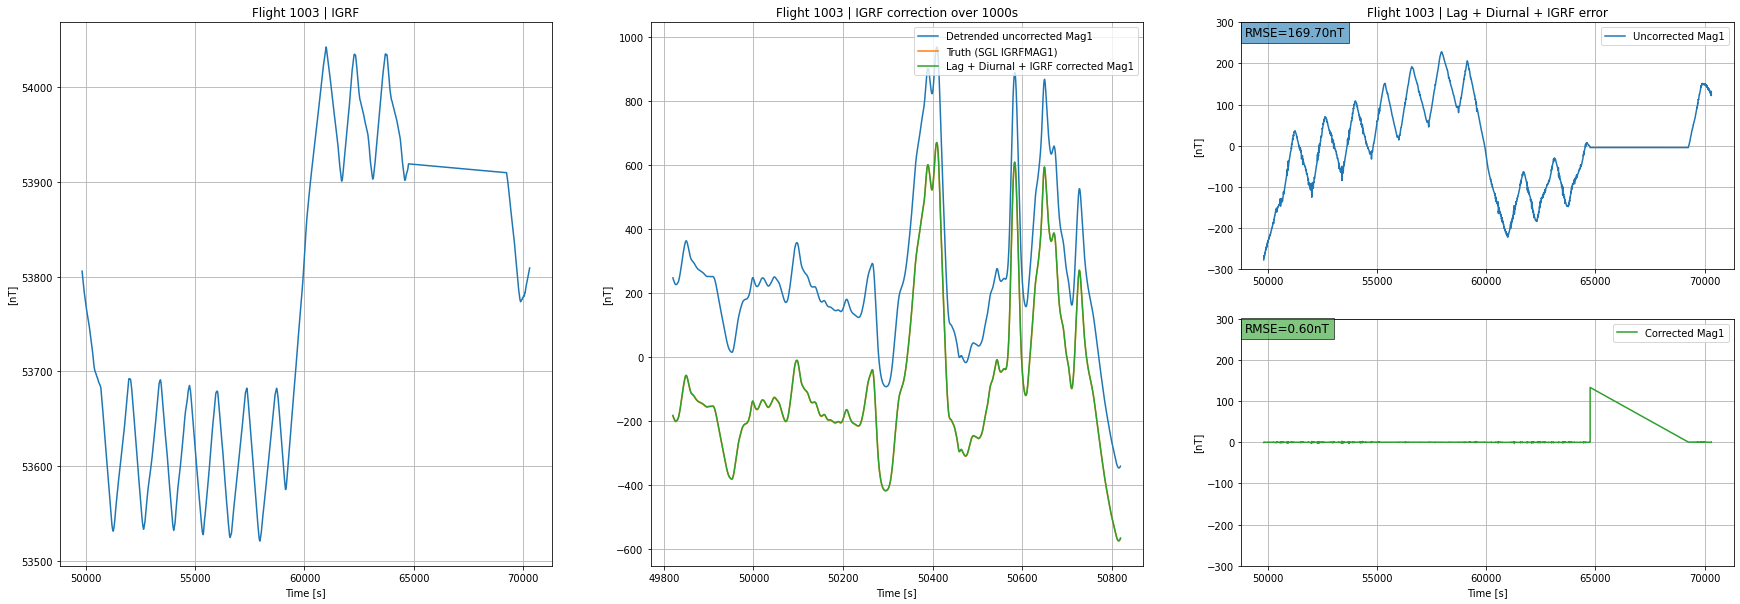

In [32]:
lat  = UNLAG_df['LAT']
lon  = UNLAG_df['LONG']
h    = UNLAG_df['BARO']*1e-3# kilometers above WGS84 ellipsoid, no impact on rmse due to low altitude
date = datetime.datetime(2020, 6, 29)

Be, Bn, Bu = ppigrf.igrf(lon,lat,h,date)

our_IGRF_cor = our_dc_cor - np.sqrt(Be**2+Bn**2+Bu**2)[0]

plt.figure(figsize=[30,10])
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,6)

# IGRF offset
ax1.plot(UNLAG_df.index,np.sqrt(Be**2+Bn**2+Bu**2)[0])
ax1.set_title(f'Flight 100{w_flight.value} | IGRF')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('[nT]')
ax1.grid()

# IGRF correction
ax2.plot(UNLAG_df.index[:10000],signal.detrend(UNLAG_df['COMPMAG1'])[:10000])
ax2.plot(UNLAG_df['IGRFMAG1'][:UNLAG_df.index[0]+1000])
ax2.plot(our_IGRF_cor[:UNLAG_df.index[0]+1000])
ax2.legend(['Detrended uncorrected Mag1','Truth (SGL IGRFMAG1)','Lag + Diurnal + IGRF corrected Mag1'],loc='upper right')
ax2.set_title(f'Flight 100{w_flight.value} | IGRF correction over 1000s')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('[nT]')
ax2.grid()

# IGRF error
uncor_rmse = magnav.rmse(UNLAG_df['COMPMAG1'],UNLAG_df['IGRFMAG1'])
cor_rmse = magnav.rmse(our_IGRF_cor,UNLAG_df['IGRFMAG1'])

ax3.plot(UNLAG_df.index,signal.detrend(UNLAG_df['IGRFMAG1']-UNLAG_df['COMPMAG1']),'C0')
ax3.grid()
ax3.set_ylabel('[nT]')
ax3.set_title(f'Flight 100{w_flight.value} | Lag + Diurnal + IGRF error')
ax3.axes.set_ylim(-300,300)
ax3.legend(['Uncorrected Mag1'],loc='upper right')
ax3.text(UNLAG_df.index[0]-850,267,f'RMSE={uncor_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C0',alpha=0.6))

ax4.plot(UNLAG_df.index,signal.detrend(UNLAG_df['IGRFMAG1']-our_IGRF_cor),'C2')
ax4.grid()
ax4.set_ylabel('[nT]')
ax4.set_xlabel('Time [s]')
ax4.axes.set_ylim(-300,300)
ax4.legend(['Corrected Mag1'],loc='upper right')
ax4.text(UNLAG_df.index[0]-850,267,f'RMSE={cor_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C2',alpha=0.6))


plt.show()

<font size="4">Interpretation of results :</font><br>
We can see that among the corrections, IGRF is the more significant one. However, this correction does not add any error to our data and the RMSE remains vey low.

## 5.5 - Tolles Lawson + corrections

In [33]:
def apply_corrections(df,lag=True,diurnal=True,igrf=True):
    
    mag_measurements = np.array(['TL_comp_mag5_cl','TL_comp_mag4_cl','TL_comp_mag3_cl','TL_comp_mag2_cl','TL_comp_mag1_cl',
                        'TL_comp_mag5_sq','TL_comp_mag4_sq','TL_comp_mag3_sq','TL_comp_mag2_sq','TL_comp_mag1_sq',
                        'TL_comp_mag5_sqcl','TL_comp_mag4_sqcl','TL_comp_mag3_sqcl','TL_comp_mag2_sqcl','TL_comp_mag1_sqcl'])
    COR_df = df
    
    # Lag cor
    if lag == True:
        
        # 0.2s correction on mag1
        unlag = df[mag_measurements[[4,9,14]]].drop([df.index[0],df.index[1]])
        unlag.index = df.index[:-2]
        
        COR_df = df.drop([df.index[-1],df.index[-2]])
        COR_df = UNLAG_df.drop(columns=mag_measurements[[4,9,14]])
        COR_df[mag_measurements[[4,9,14]]] = unlag
    
    # Diurnal cor
    if diurnal == True:
        COR_df[mag_measurements] = COR_df[mag_measurements]-np.reshape(COR_df['DIURNAL'].values,[-1,1])
    
    # IGRF cor
    lat  = COR_df['LAT']
    lon  = COR_df['LONG']
    h    = COR_df['BARO']*1e-3 # Kilometers above WGS84 ellipsoid
    date = datetime.datetime(2020, 6, 29) # Date on which the flights were made
    Be, Bn, Bu = ppigrf.igrf(lon,lat,h,date)
    
    if igrf == True:
        COR_df[mag_measurements] = COR_df[mag_measurements]-np.reshape(np.sqrt(Be**2+Bn**2+Bu**2)[0],[-1,1])

    
    return COR_df
    

In [34]:
COR_df = apply_corrections(df_sel_flight,lag=True,diurnal=True,igrf=True)

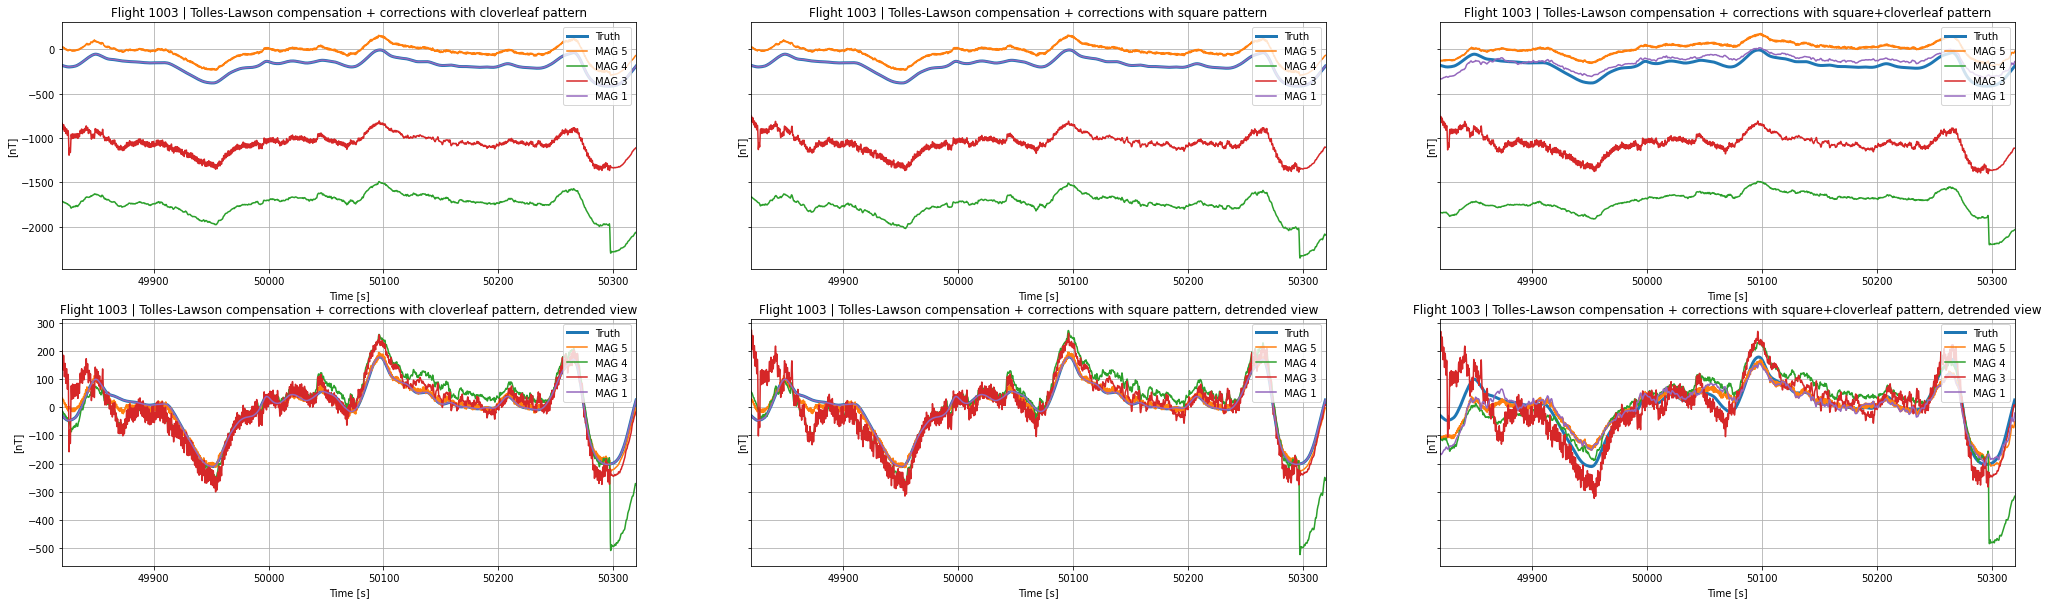

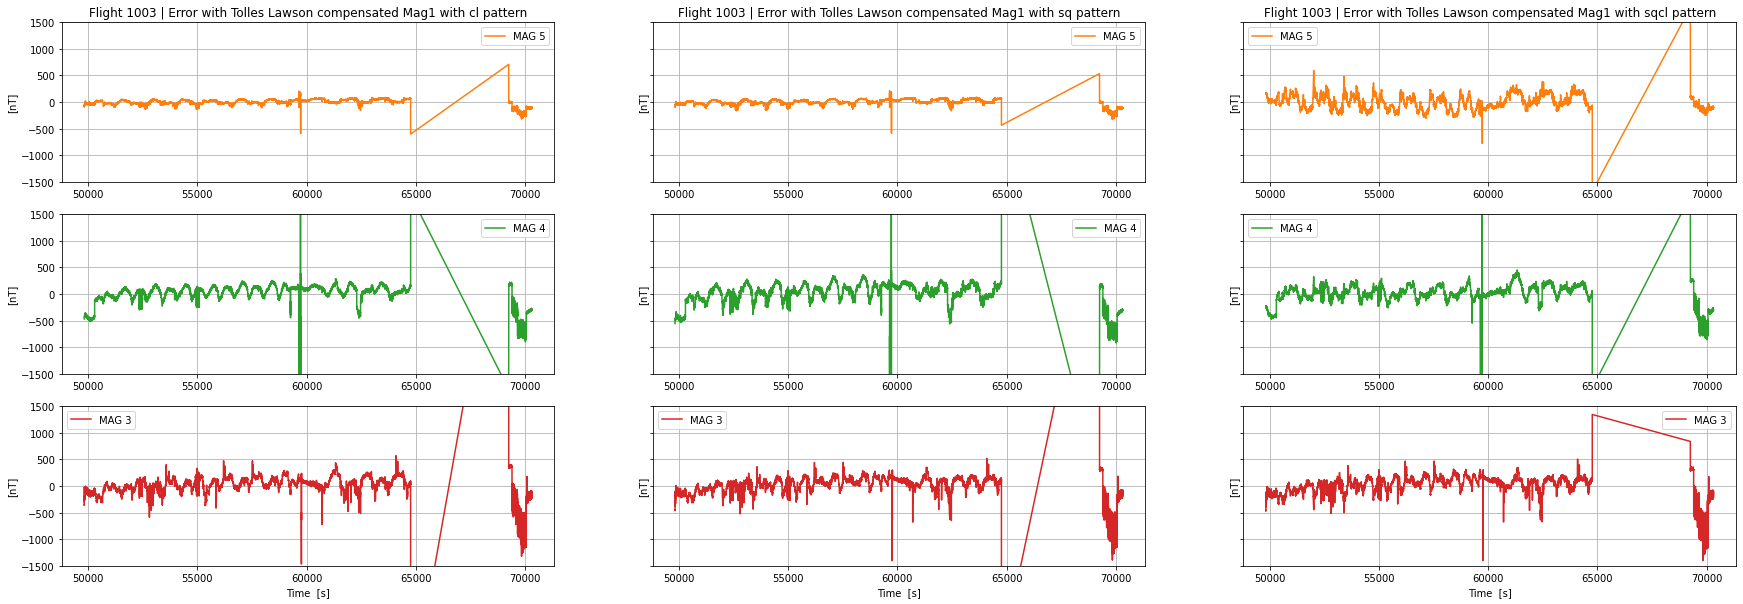


RMSE between Tolles Lowson compensated and corrected magnetometers and truth (SGL IGRFMAG1) :
╒════════════════╤══════════════════════════════════════════════╤══════════════════════════════════════════╤═════════════════════════════════════════════════════╕
│   Magnetometer │   Cloverleaf compensation + corrections RMSE │   Square compensation + corrections RMSE │   Cloverleaf+Square compensation + corrections RMSE │
╞════════════════╪══════════════════════════════════════════════╪══════════════════════════════════════════╪═════════════════════════════════════════════════════╡
│          Mag 1 │                                      0.77 nT │                                  0.82 nT │                                           169.13 nT │
├────────────────┼──────────────────────────────────────────────┼──────────────────────────────────────────┼─────────────────────────────────────────────────────┤
│          Mag 2 │                                  20883.60 nT │                         

In [36]:
fig, ([ax1,ax2,ax3],[ax4,ax5,ax6]) = plt.subplots(2,3,figsize=[35,10],sharey='row')

# Cloverleaf pattern
ax1.plot(COR_df.index[:5000],COR_df['IGRFMAG1'][:COR_df.index[0]+499.9],label='Truth',linewidth=3)
ax1.plot(COR_df.index[:5000],COR_df['TL_comp_mag5_cl'][:COR_df.index[0]+499.9],label='MAG 5')
ax1.plot(COR_df.index[:5000],COR_df['TL_comp_mag4_cl'][:COR_df.index[0]+499.9],label='MAG 4')
ax1.plot(COR_df.index[:5000],COR_df['TL_comp_mag3_cl'][:COR_df.index[0]+499.9],label='MAG 3')
ax1.plot(COR_df.index[:5000],COR_df['TL_comp_mag1_cl'][:COR_df.index[0]+499.9],label='MAG 1')

ax1.axes.set_xlim(COR_df.index[0],COR_df.index[0]+500)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('[nT]')
ax1.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation + corrections with cloverleaf pattern')
ax1.legend(loc='upper right')
ax1.grid()

ax4.plot(COR_df.index[:5000],signal.detrend(COR_df['IGRFMAG1'][:COR_df.index[0]+499.9]),label='Truth',linewidth=3)
ax4.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag5_cl'][:COR_df.index[0]+499.9]),label='MAG 5')
ax4.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag4_cl'][:COR_df.index[0]+499.9]),label='MAG 4')
ax4.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag3_cl'][:COR_df.index[0]+499.9]),label='MAG 3')
ax4.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag1_cl'][:COR_df.index[0]+499.9]),label='MAG 1')

ax4.axes.set_xlim(COR_df.index[0],COR_df.index[0]+500)
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('[nT]')
ax4.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation + corrections with cloverleaf pattern, detrended view')
ax4.legend(loc='upper right')
ax4.grid()

# Square pattern
ax2.plot(COR_df.index[:5000],COR_df['IGRFMAG1'][:COR_df.index[0]+499.9],label='Truth',linewidth=3)
ax2.plot(COR_df.index[:5000],COR_df['TL_comp_mag5_sq'][:COR_df.index[0]+499.9],label='MAG 5')
ax2.plot(COR_df.index[:5000],COR_df['TL_comp_mag4_sq'][:COR_df.index[0]+499.9],label='MAG 4')
ax2.plot(COR_df.index[:5000],COR_df['TL_comp_mag3_sq'][:COR_df.index[0]+499.9],label='MAG 3')
ax2.plot(COR_df.index[:5000],COR_df['TL_comp_mag1_sq'][:COR_df.index[0]+499.9],label='MAG 1')

ax2.axes.set_xlim(COR_df.index[0],COR_df.index[0]+500)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('[nT]')
ax2.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation + corrections with square pattern')
ax2.legend(loc='upper right')
ax2.grid()

ax5.plot(COR_df.index[:5000],signal.detrend(COR_df['IGRFMAG1'][:COR_df.index[0]+499.9]),label='Truth',linewidth=3)
ax5.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag5_sq'][:COR_df.index[0]+499.9]),label='MAG 5')
ax5.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag4_sq'][:COR_df.index[0]+499.9]),label='MAG 4')
ax5.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag3_sq'][:COR_df.index[0]+499.9]),label='MAG 3')
ax5.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag1_sq'][:COR_df.index[0]+499.9]),label='MAG 1')

ax5.axes.set_xlim(COR_df.index[0],COR_df.index[0]+500)
ax5.set_xlabel('Time [s]')
ax5.set_ylabel('[nT]')
ax5.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation + corrections with square pattern, detrended view')
ax5.legend(loc='upper right')
ax5.grid()

# Square+Cloverleaf pattern
ax3.plot(COR_df.index[:5000],COR_df['IGRFMAG1'][:COR_df.index[0]+499.9],label='Truth',linewidth=3)
ax3.plot(COR_df.index[:5000],COR_df['TL_comp_mag5_sqcl'][:COR_df.index[0]+499.9],label='MAG 5')
ax3.plot(COR_df.index[:5000],COR_df['TL_comp_mag4_sqcl'][:COR_df.index[0]+499.9],label='MAG 4')
ax3.plot(COR_df.index[:5000],COR_df['TL_comp_mag3_sqcl'][:COR_df.index[0]+499.9],label='MAG 3')
ax3.plot(COR_df.index[:5000],COR_df['TL_comp_mag1_sqcl'][:COR_df.index[0]+499.9],label='MAG 1')

ax3.axes.set_xlim(COR_df.index[0],COR_df.index[0]+500)
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('[nT]')
ax3.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation + corrections with square+cloverleaf pattern')
ax3.legend(loc='upper right')
ax3.grid()

ax6.plot(COR_df.index[:5000],signal.detrend(COR_df['IGRFMAG1'][:COR_df.index[0]+499.9]),label='Truth',linewidth=3)
ax6.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag5_sqcl'][:COR_df.index[0]+499.9]),label='MAG 5')
ax6.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag4_sqcl'][:COR_df.index[0]+499.9]),label='MAG 4')
ax6.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag3_sqcl'][:COR_df.index[0]+499.9]),label='MAG 3')
ax6.plot(COR_df.index[:5000],signal.detrend(COR_df['TL_comp_mag1_sqcl'][:COR_df.index[0]+499.9]),label='MAG 1')

ax6.axes.set_xlim(COR_df.index[0],COR_df.index[0]+500)
ax6.set_xlabel('Time [s]')
ax6.set_ylabel('[nT]')
ax6.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation + corrections with square+cloverleaf pattern, detrended view')
ax6.legend(loc='upper right')
ax6.grid()

plt.show()

fig, ([ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9]) = plt.subplots(3,3,figsize=[30,10],sharey=True)

ax1.plot(COR_df.index,signal.detrend(COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag5_cl'])),'C1',label='MAG 5')
ax4.plot(COR_df.index,signal.detrend(COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag4_cl'])),'C2',label='MAG 4')
ax7.plot(COR_df.index,signal.detrend(COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag3_cl'])),'C3',label='MAG 3')

ax2.plot(COR_df.index,signal.detrend(COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag5_sq'])),'C1',label='MAG 5')
ax5.plot(COR_df.index,signal.detrend(COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag4_sq'])),'C2',label='MAG 4')
ax8.plot(COR_df.index,signal.detrend(COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag3_sq'])),'C3',label='MAG 3')

ax3.plot(COR_df.index,signal.detrend(COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag5_sqcl'])),'C1',label='MAG 5')
ax6.plot(COR_df.index,signal.detrend(COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag4_sqcl'])),'C2',label='MAG 4')
ax9.plot(COR_df.index,signal.detrend(COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag3_sqcl'])),'C3',label='MAG 3')

ax1.set_ylim([-1500,1500])
ax1.grid(),ax2.grid(),ax3.grid(),ax4.grid(),ax5.grid(),ax6.grid(),ax7.grid(),ax8.grid(),ax9.grid()
ax1.legend(),ax2.legend(),ax3.legend(),ax4.legend(),ax5.legend(),ax6.legend(),ax7.legend(),ax8.legend(),ax9.legend()
ax7.set_xlabel('Time  [s]'),ax8.set_xlabel('Time  [s]'),ax9.set_xlabel('Time  [s]')
ax1.set_ylabel('[nT]'),ax2.set_ylabel('[nT]'),ax3.set_ylabel('[nT]'),ax4.set_ylabel('[nT]'),ax5.set_ylabel('[nT]'),ax6.set_ylabel('[nT]'),ax7.set_ylabel('[nT]'),ax8.set_ylabel('[nT]'),ax9.set_ylabel('[nT]')
ax1.set_title(f'Flight 100{w_flight.value} | Error with Tolles Lawson compensated Mag1 with cl pattern')
ax2.set_title(f'Flight 100{w_flight.value} | Error with Tolles Lawson compensated Mag1 with sq pattern')
ax3.set_title(f'Flight 100{w_flight.value} | Error with Tolles Lawson compensated Mag1 with sqcl pattern')
plt.show()

RMSE_mag1_sq = magnav.rmse(COR_df['TL_comp_mag1_sq'],COR_df['IGRFMAG1'])
RMSE_mag2_sq = magnav.rmse(COR_df['TL_comp_mag2_sq'],COR_df['IGRFMAG1'])
RMSE_mag3_sq = magnav.rmse(COR_df['TL_comp_mag3_sq'],COR_df['IGRFMAG1'])
RMSE_mag4_sq = magnav.rmse(COR_df['TL_comp_mag4_sq'],COR_df['IGRFMAG1'])
RMSE_mag5_sq = magnav.rmse(COR_df['TL_comp_mag5_sq'],COR_df['IGRFMAG1'])

RMSE_mag1_cl = magnav.rmse(COR_df['TL_comp_mag1_cl'],COR_df['IGRFMAG1'])
RMSE_mag2_cl = magnav.rmse(COR_df['TL_comp_mag2_cl'],COR_df['IGRFMAG1'])
RMSE_mag3_cl = magnav.rmse(COR_df['TL_comp_mag3_cl'],COR_df['IGRFMAG1'])
RMSE_mag4_cl = magnav.rmse(COR_df['TL_comp_mag4_cl'],COR_df['IGRFMAG1'])
RMSE_mag5_cl = magnav.rmse(COR_df['TL_comp_mag5_cl'],COR_df['IGRFMAG1'])

RMSE_mag1_sqcl = magnav.rmse(COR_df['TL_comp_mag1_sqcl'],COR_df['IGRFMAG1'])
RMSE_mag2_sqcl = magnav.rmse(COR_df['TL_comp_mag2_sqcl'],COR_df['IGRFMAG1'])
RMSE_mag3_sqcl = magnav.rmse(COR_df['TL_comp_mag3_sqcl'],COR_df['IGRFMAG1'])
RMSE_mag4_sqcl = magnav.rmse(COR_df['TL_comp_mag4_sqcl'],COR_df['IGRFMAG1'])
RMSE_mag5_sqcl = magnav.rmse(COR_df['TL_comp_mag5_sqcl'],COR_df['IGRFMAG1'])

table = [['Magnetometer','Cloverleaf compensation + corrections RMSE','Square compensation + corrections RMSE','Cloverleaf+Square compensation + corrections RMSE'],
         ['Mag 1',f'{RMSE_mag1_cl:.2f} nT',f'{RMSE_mag1_sq:.2f} nT',f'{RMSE_mag1_sqcl:.2f} nT'],
         ['Mag 2',f'{RMSE_mag2_cl:.2f} nT',f'{RMSE_mag2_sq:.2f} nT',f'{RMSE_mag2_sqcl:.2f} nT'],
         ['Mag 3',f'{RMSE_mag3_cl:.2f} nT',f'{RMSE_mag3_sq:.2f} nT',f'{RMSE_mag3_sqcl:.2f} nT'],
         ['Mag 4',f'{RMSE_mag4_cl:.2f} nT',f'{RMSE_mag4_sq:.2f} nT',f'{RMSE_mag4_sqcl:.2f} nT'],
         ['Mag 5',f'{RMSE_mag5_cl:.2f} nT',f'{RMSE_mag5_sq:.2f} nT',f'{RMSE_mag5_sqcl:.2f} nT']]

print('\nRMSE between Tolles Lowson compensated and corrected magnetometers and truth (SGL IGRFMAG1) :')
print(tabulate(table,headers='firstrow',tablefmt='fancy_grid',stralign='right'))

<font size="4">Interpretation of results :</font><br>
We can see that the RMSEs of the Tolles Lawson compensation and Tolles Lawson compensation + corrections are identical. This is due to the fact that the corrections are mainly constants. We can see that on the detrended view and the RMSE that the magnetometer 5 is close to the magnetometer 1. Magnetometers 3 and 4 follow the trend on magnetometer 1 but their RMSE is more significant with larger deviations. [Same conclusion](#explication) than before for the error between the truth and the magnetometers.

# 6 - Feature selection

Now that we have most of our data ready to be used and we have a better understanding of the data, we can start selecting the features. First intuition :<br>
- Magnetometer 5 will be the most useful variable for the reconstruction of the truth
- Measurements of electrical elements near the selected magnetometers will be useful
- The attitude of the aircraft will also be useful

The feature selection was made on flights 1002 and 1003 as flights 1004 and 1005 are survey flights.

## 6.1 - Data distribution

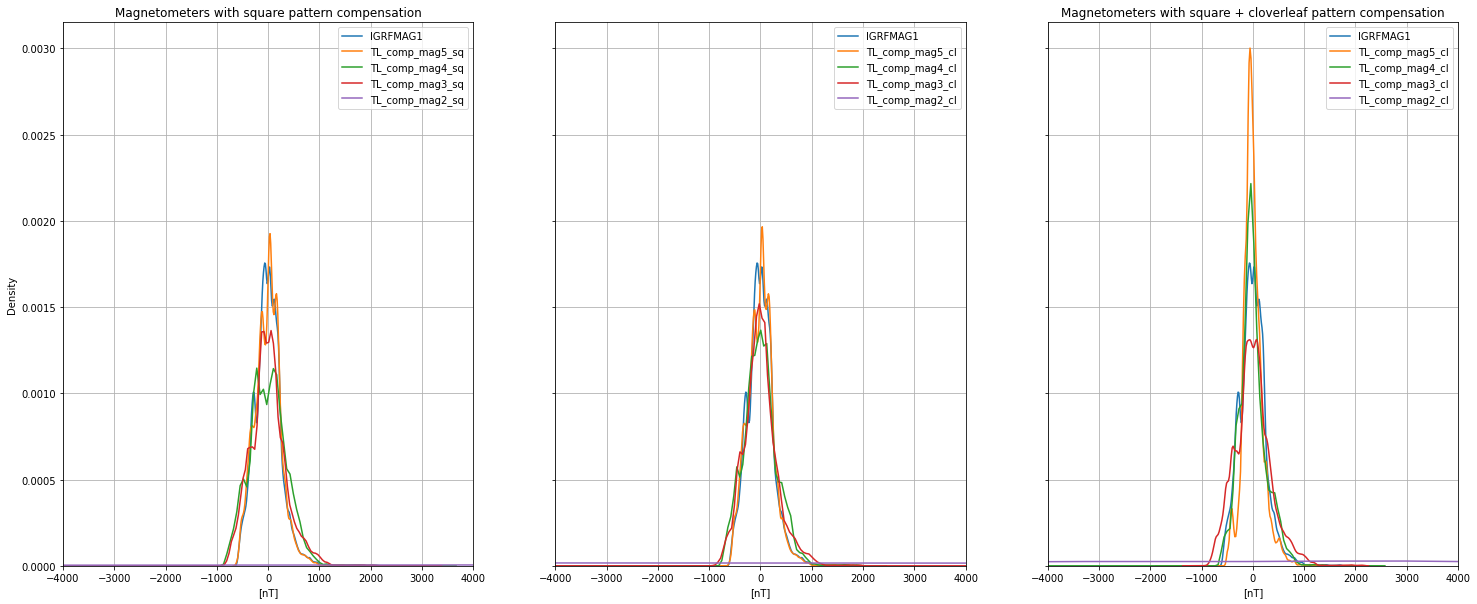

In [45]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[25,10],sharey=True)

sns.kdeplot(data=signal.detrend(COR_df['IGRFMAG1']),ax=ax1,label='IGRFMAG1')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag5_sq']),ax=ax1,label='TL_comp_mag5_sq')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag4_sq']),ax=ax1,label='TL_comp_mag4_sq')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag3_sq']),ax=ax1,label='TL_comp_mag3_sq')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag2_sq']),ax=ax1,label='TL_comp_mag2_sq')

ax1.set_xlabel('[nT]')
ax1.set_title('Magnetometers with square pattern compensation')
ax1.set_xlim(left=-4000,right=4000)
ax1.grid()
ax1.legend()

sns.kdeplot(data=signal.detrend(COR_df['IGRFMAG1']),ax=ax2,label='IGRFMAG1')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag5_cl']),ax=ax2,label='TL_comp_mag5_cl')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag4_cl']),ax=ax2,label='TL_comp_mag4_cl')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag3_cl']),ax=ax2,label='TL_comp_mag3_cl')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag2_cl']),ax=ax2,label='TL_comp_mag2_cl')

ax2.set_xlabel('[nT]')
ax3.set_title('Magnetometers with cloverleaf pattern compensation')
ax2.set_xlim(left=-4000,right=4000)
ax2.grid()
ax2.legend()

sns.kdeplot(data=signal.detrend(COR_df['IGRFMAG1']),ax=ax3,label='IGRFMAG1')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag5_sqcl']),ax=ax3,label='TL_comp_mag5_cl')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag4_sqcl']),ax=ax3,label='TL_comp_mag4_cl')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag3_sqcl']),ax=ax3,label='TL_comp_mag3_cl')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag2_sqcl']),ax=ax3,label='TL_comp_mag2_cl')

ax3.set_xlabel('[nT]')
ax3.set_title('Magnetometers with square + cloverleaf pattern compensation')
ax3.set_xlim(left=-4000,right=4000)
ax3.grid()
ax3.legend()

plt.show()

<font size="4">Interpretation of results :</font><br>
Several elements emerge from the density plots :
- The magnetometer 5 has a distribution very close to the truth and seems to be a good choice as a variable for our model.
- Magnetometer 2 is completely off mark
- Magnetometers 3 and 4 have distributions closer to the truth in the case of a cloverleaf compensation

With this first approach we can already have information about the variables to select. A priori the magnetometer 5 is a very good candidate contrary to the magnetometer 2. As for the difference between the two compensations, it is not equal for all magnetometers. The cloverleaf compensation seems to be more interesting for magnetometers 3 and 4 and has no visible impact for magnetometer 5. It is reasonable to think that the cloverleaf compensation captures more of the aircraft's disturbing elements and this can be seen on magnetometers that are noisy. The mix of square + cloverleaf compensation seems not very relevant.

## 6.2 - Correlation

In this section we will use two different types of correlation to be able to show links between variables and the truth or between certain variables themselves.<br>
For this, 2 types of correlations are usable for our data :
- Pearson correlation coefficient
- Spearman's rank correlation coefficient
<br><br>

<font size='3'><b>Pearson correlation coefficient</b></font>
<br><br>
Pearson correlation coefficient is a measure of linear correlation between two sets of data. It is the ratio between the covariance of two variables and the product of their standard deviations. The value is between -1 and 1 where 1 represent a perfect correlation, -1 a perfect opposite correlation and 0 no correlation.<br><br>
<font size='4'>
    $\rho_{X,Y}=\frac{cov(X,Y)}{\sigma_{X}\sigma_{Y}}$
</font>

- $cov$ is the covariance
- $\sigma_{X}$ is the standard deviation of X
- $\sigma_{Y}$ is the standrad deviation of Y
<br><br>

<font size='3'><b>Spearman's rank correlation coefficient</b></font>
<br><br>
Spearman's rank correlation coefficient is a nonparametric (distribution-free method) measure of rank correlation (ordering the labels of a specific variables). It assesses how well the relationship between two variables can be described using a monotonic function (a function that is entirely non-increasing or non-decreasing). The Spearman correlation between two variables is equal to the Pearson correlation between the rank values of those 2 variables. While Pearson correlation assesses linear relationship, Spearman's correlation assesses monotonic relationships (wether linear or not). Same as Pearson correlation, the value is between -1 and 1 where 1 represent a perfect correlation, -1 a perfect opposite correlation and 0 no correlation.<br><br>
<font size='4'>
    $r_{s}=\rho_{R(X),R(Y)}=\frac{cov(R(X),R(Y))}{\sigma_{R(X)}\sigma_{R(Y)}}$
</font>

- $rho$ denotes the usual Pearson correlation coefficient, but applied to the rank variables
- $cov(R(X),R(Y))$ is the covariance of the rank variables
- $\sigma_{R(X)}$ and $\sigma_{R(Y)}$ iare the standrad deviation of the rank variables

Example available [here](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient#Example).<br>
The spearman method is interesting because it is robust to outliers.

In [39]:
to_drop = ['LINE','FLT','UNCOMPMAG1','COMPMAG1','LAGMAG1','DCMAG1','TL_comp_mag1_sq','TL_comp_mag1_cl','TL_comp_mag1_sqcl']

corr_sglcomp          = COR_df.drop(columns=to_drop).corr(method='pearson')[['IGRFMAG1']].abs().sort_values(by='IGRFMAG1',ascending=False)
corr_sglcomp_spearman = COR_df.drop(columns=to_drop).corr(method='spearman')[['IGRFMAG1']].abs().sort_values(by='IGRFMAG1',ascending=False)

corr_sglcomp          = corr_sglcomp.drop('IGRFMAG1')
corr_sglcomp_spearman = corr_sglcomp_spearman.drop('IGRFMAG1')

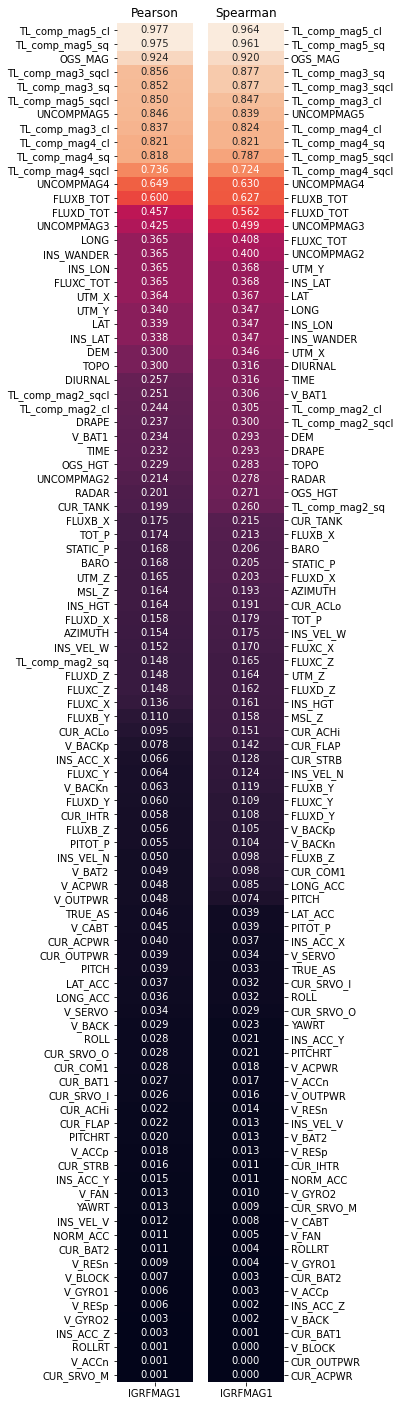

In [40]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[3,25])

df_corr_htmap = sns.heatmap(corr_sglcomp,annot=True,fmt=".3f",ax=ax1,cbar=False)
df_corr_htmap_spear = sns.heatmap(corr_sglcomp_spearman,annot=True,fmt=".3f",ax=ax2,cbar=False)

df_corr_htmap_spear.set_title('Spearman')
df_corr_htmap.set_title('Pearson')
df_corr_htmap_spear.yaxis.tick_right()
df_corr_htmap_spear.set_yticklabels(df_corr_htmap_spear.get_yticklabels(),rotation=0)
plt.show()

<font size="4">Interpretation of results :</font><br>
Before analyzing the results there are two points to consider :
- Pearson's and Spearman's correlations put forward linear or monotonic correlations. This means that there may be other more complex relationships between the variables that will not be highlighted here.
- The correlation above is between the truth ('IGRFMAG1', magnetometer 1 with the previous corrections) and the other variables of the dataset. But the truth is based on a magnetometer at the end of a pole that aims to get as far away as possible from the effects of the plane. This means that the truth captures very little or no effect of the aircraft. To compensate for this, we take the magnetometers that are most correlated with the truth and then correlate the selected magnetometers with the other variables in the dataset.

As we can see the magnetometer 5 is very correlated with the truth. In both cases the cloverleaf pattern seems to give slightly more information than the square pattern. The mix of the two patterns does not seem to be very efficient as concluded before.

## 6.3 - Mutual informations

In [48]:
non_float = np.sum(df_sel_flight.dtypes != float)
print(f"Number of non float value : {non_float} (if different from 0, make_mi_scores don't work)")

Number of non float value : 0 (if different from 0, make_mi_scores don't work)


In [49]:
with pd.option_context('display.max_rows',None,'display.max_columns',None):
    print(df_sel_flight.isna().sum())

MSL_Z                   0
NORM_ACC                0
BARO                    0
CUR_ACHi                0
CUR_ACLo                0
CUR_ACPWR               0
CUR_BAT1                0
CUR_BAT2                0
CUR_COM1                0
CUR_FLAP                0
CUR_IHTR                0
CUR_OUTPWR              0
CUR_SRVO_I              0
CUR_SRVO_M              0
CUR_SRVO_O              0
CUR_STRB                0
CUR_TANK                0
DEM                     0
DIURNAL                 0
DRAPE                5225
FLT                     0
FLUXB_TOT               0
FLUXB_X                 0
FLUXB_Y                 0
FLUXB_Z                 0
FLUXC_TOT               0
FLUXC_X                 0
FLUXC_Y                 0
FLUXC_Z                 0
FLUXD_TOT               0
FLUXD_X                 0
FLUXD_Y                 0
FLUXD_Z                 0
INS_ACC_X               0
INS_ACC_Y               0
INS_ACC_Z               0
INS_HGT                 0
AZIMUTH                 0
INS_LAT     

In [50]:
def make_mi_scores(X,y,n_neighbors=3):
    
    mi_scores = mutual_info_regression(X,y,n_neighbors=n_neighbors)
    mi_scores = pd.Series(mi_scores, name = 'Mutual Informations scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores

def plot_mi_scores(scores):
    
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width,scores)
    plt.yticks(width,ticks)
    plt.grid()
    plt.title("Mutual Information Scores")

In [51]:
mi_scores = make_mi_scores(df_sel_flight.drop(columns=['IGRFMAG1','DRAPE','OGS_MAG','OGS_HGT']),df_sel_flight['IGRFMAG1'],n_neighbors=5)

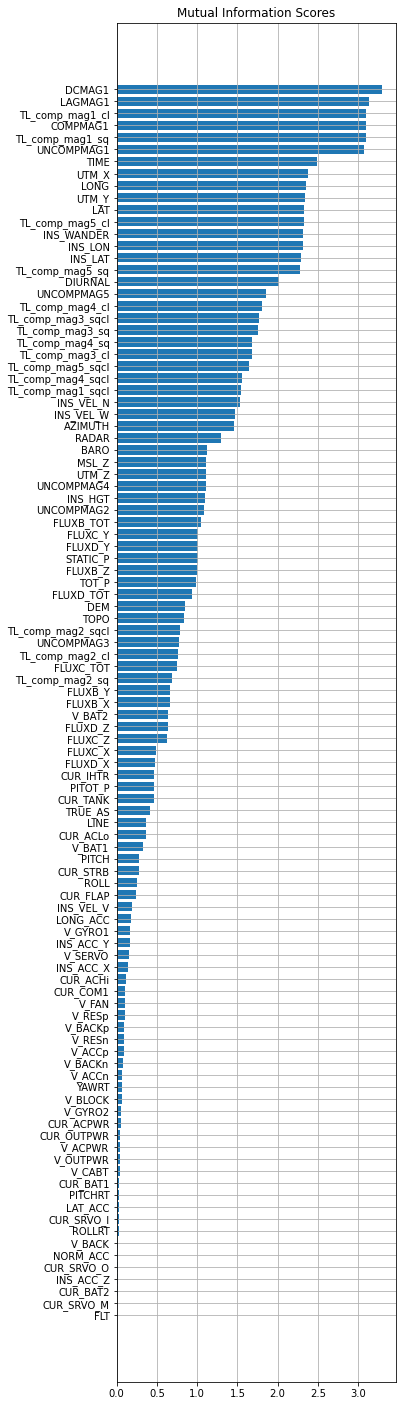

In [52]:
fig, ax = plt.subplots(figsize=[5,25])
plot_mi_scores(mi_scores)

## XGBOOST as feature selection

In [111]:
import xgboost as xgb

In [112]:
X = COR_df.drop(['IGRFMAG1','COMPMAG1','DCMAG1','LAGMAG1','UNCOMPMAG1','TL_comp_mag1_sq','TL_comp_mag1_cl','TL_comp_mag1_sqcl'],axis=1)
y = COR_df['IGRFMAG1']

In [113]:
xgb_params = {
    'eta' : 0.05,
    'max_depth' : 10,
    'subsample' : 1.0,
    'colsample_bytree' : 0.7,
    'objective' : 'reg:squarederror',
    'eval_metric' : 'rmse',
}

In [114]:
dtrain = xgb.DMatrix(X,y,feature_names=X.columns.values)
model = xgb.train(dict(xgb_params),dtrain,num_boost_round=100)
remain_num = 99

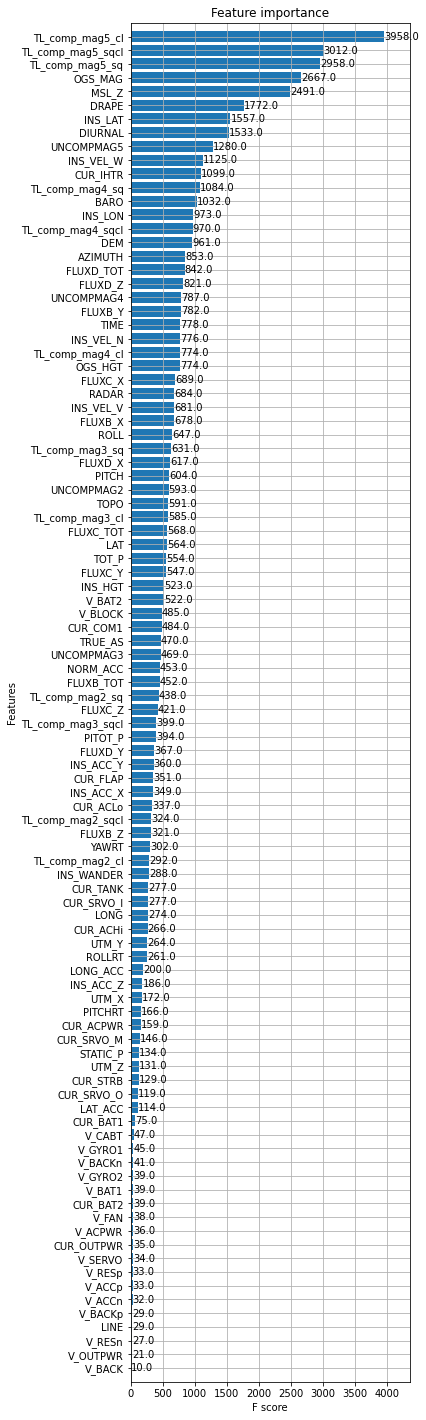

In [115]:
fig, ax = plt.subplots(figsize=[5,25])
xgb.plot_importance(model,max_num_features=remain_num,height=0.8, ax=ax)
plt.show()

2.4922883354424266

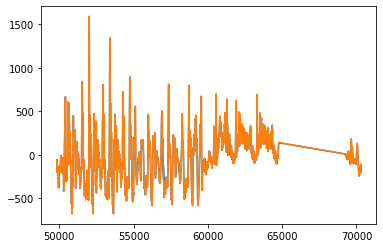

In [117]:
pred = model.predict(dtrain)
plt.plot(COR_df.index,pred)
plt.plot(COR_df['IGRFMAG1'])
magnav.rmse(pred,COR_df['IGRFMAG1'])

In [118]:
from sklearn.feature_selection import SelectKBest, f_regression
X = COR_df.drop(['IGRFMAG1','COMPMAG1','DCMAG1','LAGMAG1','UNCOMPMAG1','TL_comp_mag1_sq','TL_comp_mag1_cl','TL_comp_mag1_sqcl','DRAPE','OGS_MAG','OGS_HGT','FLT'],axis=1)
y = COR_df['IGRFMAG1']

fs = SelectKBest(score_func=f_regression, k=20)
X_selected = fs.fit_transform(X,y)
print(X_selected)
cols = fs.get_support(indices=True)
features_df_new = X.iloc[:,cols]
features_df_new.columns

[[ 5.66294090e+04  5.38112820e+04 -1.32055270e+00 ... -1.83604176e+03
  -1.31342211e+02  5.28342540e+04]
 [ 5.66290590e+04  5.38107590e+04 -1.32055200e+00 ... -1.83660996e+03
  -1.30399997e+02  5.28329800e+04]
 [ 5.66279530e+04  5.38108600e+04 -1.32055120e+00 ... -1.83697308e+03
  -1.28371957e+02  5.28323050e+04]
 ...
 [ 5.74636800e+04  5.51339860e+04 -1.32056450e+00 ... -1.73758547e+03
   3.74903362e+01  5.28502000e+04]
 [ 5.74481610e+04  5.51178930e+04 -1.32056350e+00 ... -1.73640759e+03
   3.70989380e+01  5.28431810e+04]
 [ 5.74335780e+04  5.51043140e+04 -1.32056240e+00 ... -1.73538009e+03
   3.95800367e+01  5.28383150e+04]]


Index(['FLUXC_TOT', 'FLUXD_TOT', 'INS_LON', 'INS_WANDER', 'LONG', 'UNCOMPMAG3',
       'UNCOMPMAG4', 'UNCOMPMAG5', 'UTM_X', 'UTM_Y', 'TL_comp_mag3_sq',
       'TL_comp_mag4_sq', 'TL_comp_mag5_sq', 'TL_comp_mag3_cl',
       'TL_comp_mag4_cl', 'TL_comp_mag5_cl', 'TL_comp_mag3_sqcl',
       'TL_comp_mag4_sqcl', 'TL_comp_mag5_sqcl', 'FLUXB_TOT'],
      dtype='object')

### 6.1.3 - PCA

In [60]:
def plot_variance(pca,width=8):
    fig, axs = plt.subplots(1,2)
    n = pca.n_components_
    grid = np.arange(1,n+1)
    
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(xlabel='Component',title='% Explained Variance', ylim=(0.0,1.0))
    
    # Cumulative variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0,grid],np.r_[0,cv],"o-")
    axs[1].set(xlabel='Component',title='% Cumulative Variance', ylim=(0.0,1.0))
    
    fig.set(figwidth=width)

In [61]:
df_sel_flight_scaled = (df_sel_flight.drop(columns=['LINE','IGRFMAG1','DRAPE','OGS_MAG','OGS_HGT'])-df_sel_flight.drop(columns=['LINE','IGRFMAG1','DRAPE','OGS_MAG','OGS_HGT']).mean(axis=0))/df_sel_flight.drop(columns=['LINE','IGRFMAG1','DRAPE','OGS_MAG','OGS_HGT']).std(axis=0)

var = 0.90
pca = PCA(n_components = var)
pca.fit(df_sel_flight_scaled)

components = len(pca.explained_variance_ratio_*100)
print(f'Number of components needed to explain {var*100}% of variance: {components}\n')

plot_variance(pca,width=15)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
print('=============================================================================================')
print('|                     Top 5 most important features in each component                       |')
print('=============================================================================================')

pca_components = abs(pca.components_)
for row in range(pca_components.shape[0]):
    temp = np.argpartition(-(pca_components[row]),5)
    indices = temp[np.argsort((-pca_components[row])[temp])][:5]
    print(f'Component {row}: {df_sel_flight_scaled.columns[indices].to_list()}')

In [ ]:
df_sel_flight_PCA = pca.transform(df_sel_flight_scaled)

## 6.2 - Searching for other useful data

Creation residue between true and mags

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))

df_corr = pd.DataFrame()

# Residue between uncomp mags and true - no rescale 
df_corr['res_MAG5'] = df_sel_flight['IGRFMAG1']-signal.detrend(df_sel_flight['UNCOMPMAG5'])
df_corr['res_MAG4'] = df_sel_flight['IGRFMAG1']-signal.detrend(df_sel_flight['UNCOMPMAG4'])
df_corr['res_MAG3'] = df_sel_flight['IGRFMAG1']-signal.detrend(df_sel_flight['UNCOMPMAG3'])
df_corr['res_MAG2'] = df_sel_flight['IGRFMAG1']-signal.detrend(df_sel_flight['UNCOMPMAG2'])

# Residue between uncomp mags and true - [-1,1] rescale
scaler.fit(np.reshape(df_corr['res_MAG5'].tolist(),(-1,1)))
df_corr['res_MAG5_rsc'] = scaler.transform(np.reshape(df_corr['res_MAG5'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG4'].tolist(),(-1,1)))
df_corr['res_MAG4_rsc'] = scaler.transform(np.reshape(df_corr['res_MAG4'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG3'].tolist(),(-1,1)))
df_corr['res_MAG3_rsc'] = scaler.transform(np.reshape(df_corr['res_MAG3'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG2'].tolist(),(-1,1)))
df_corr['res_MAG2_rsc'] = scaler.transform(np.reshape(df_corr['res_MAG2'].tolist(),(-1,1)))

# Residue between TL square pattern comp mags and true - no rescale
df_corr['res_MAG5_tlsq'] = df_sel_flight['IGRFMAG1']-signal.detrend(df_sel_flight['TL_comp_mag5_sq'])
df_corr['res_MAG4_tlsq'] = df_sel_flight['IGRFMAG1']-signal.detrend(df_sel_flight['TL_comp_mag4_sq'])
df_corr['res_MAG3_tlsq'] = df_sel_flight['IGRFMAG1']-signal.detrend(df_sel_flight['TL_comp_mag3_sq'])
df_corr['res_MAG2_tlsq'] = df_sel_flight['IGRFMAG1']-signal.detrend(df_sel_flight['TL_comp_mag2_sq'])

# Residue between TL square pattern comp mags and true - [-1,1] rescale
scaler.fit(np.reshape(df_corr['res_MAG5_tlsq'].tolist(),(-1,1)))
df_corr['res_MAG5_rsc_tlsq'] = scaler.transform(np.reshape(df_corr['res_MAG5_tlsq'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG4_tlsq'].tolist(),(-1,1)))
df_corr['res_MAG4_rsc_tlsq'] = scaler.transform(np.reshape(df_corr['res_MAG4_tlsq'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG3_tlsq'].tolist(),(-1,1)))
df_corr['res_MAG3_rsc_tlsq'] = scaler.transform(np.reshape(df_corr['res_MAG3_tlsq'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG2_tlsq'].tolist(),(-1,1)))
df_corr['res_MAG2_rsc_tlsq'] = scaler.transform(np.reshape(df_corr['res_MAG2_tlsq'].tolist(),(-1,1)))

# Residue between TL cloverleaf pattern comp mags and true - no rescale
df_corr['res_MAG5_tlcl'] = df_sel_flight['IGRFMAG1']-signal.detrend(df_sel_flight['TL_comp_mag5_cl'])
df_corr['res_MAG4_tlcl'] = df_sel_flight['IGRFMAG1']-signal.detrend(df_sel_flight['TL_comp_mag4_cl'])
df_corr['res_MAG3_tlcl'] = df_sel_flight['IGRFMAG1']-signal.detrend(df_sel_flight['TL_comp_mag3_cl'])
df_corr['res_MAG2_tlcl'] = df_sel_flight['IGRFMAG1']-signal.detrend(df_sel_flight['TL_comp_mag2_cl'])

# Residue between TL cloverleaf pattern comp mags and true - [-1,1] rescale
scaler.fit(np.reshape(df_corr['res_MAG5_tlcl'].tolist(),(-1,1)))
df_corr['res_MAG5_rsc_tlcl'] = scaler.transform(np.reshape(df_corr['res_MAG5_tlcl'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG4_tlcl'].tolist(),(-1,1)))
df_corr['res_MAG4_rsc_tlcl'] = scaler.transform(np.reshape(df_corr['res_MAG4_tlcl'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG3_tlcl'].tolist(),(-1,1)))
df_corr['res_MAG3_rsc_tlcl'] = scaler.transform(np.reshape(df_corr['res_MAG3_tlcl'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG2_tlcl'].tolist(),(-1,1)))
df_corr['res_MAG2_rsc_tlcl'] = scaler.transform(np.reshape(df_corr['res_MAG2_tlcl'].tolist(),(-1,1)))

# Residue between TL square+cloverleaf pattern comp mags and true - no rescale
df_corr['res_MAG5_tlsqcl'] = df_sel_flight['IGRFMAG1']-signal.detrend(df_sel_flight['TL_comp_mag5_sqcl'])
df_corr['res_MAG4_tlsqcl'] = df_sel_flight['IGRFMAG1']-signal.detrend(df_sel_flight['TL_comp_mag4_sqcl'])
df_corr['res_MAG3_tlsqcl'] = df_sel_flight['IGRFMAG1']-signal.detrend(df_sel_flight['TL_comp_mag3_sqcl'])
df_corr['res_MAG2_tlsqcl'] = df_sel_flight['IGRFMAG1']-signal.detrend(df_sel_flight['TL_comp_mag2_sqcl'])


# Residue between TL square+cloverleaf pattern comp mags and true - [-1,1] rescale
scaler.fit(np.reshape(df_corr['res_MAG5_tlsqcl'].tolist(),(-1,1)))
df_corr['res_MAG5_rsc_tlsqcl'] = scaler.transform(np.reshape(df_corr['res_MAG5_tlsqcl'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG4_tlsqcl'].tolist(),(-1,1)))
df_corr['res_MAG4_rsc_tlsqcl'] = scaler.transform(np.reshape(df_corr['res_MAG4_tlsqcl'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG3_tlsqcl'].tolist(),(-1,1)))
df_corr['res_MAG3_rsc_tlsqcl'] = scaler.transform(np.reshape(df_corr['res_MAG3_tlsqcl'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG2_tlsqcl'].tolist(),(-1,1)))
df_corr['res_MAG2_rsc_tlsqcl'] = scaler.transform(np.reshape(df_corr['res_MAG2_tlsqcl'].tolist(),(-1,1)))

In [ ]:
variables = ['CUR_ACHi', 'CUR_ACLo', 'CUR_ACPWR', 'CUR_BAT1', 'CUR_BAT2', 'CUR_COM1',
       'CUR_FLAP', 'CUR_IHTR', 'CUR_OUTPWR', 'CUR_SRVO_I', 'CUR_SRVO_M',
       'CUR_SRVO_O', 'CUR_STRB', 'CUR_TANK', 'DIURNAL', 'FLUXB_TOT', 'FLUXB_X',
       'FLUXB_Y', 'FLUXB_Z', 'FLUXC_TOT', 'FLUXC_X', 'FLUXC_Y', 'FLUXC_Z',
       'FLUXD_TOT', 'FLUXD_X', 'FLUXD_Y', 'FLUXD_Z', 'INS_ACC_X', 'INS_ACC_Y',
       'INS_ACC_Z', 'AZIMUTH', 'PITCH', 'ROLL','V_ACCn', 'V_ACCp',
       'V_ACPWR', 'V_BACK', 'V_BACKn', 'V_BACKp', 'V_BAT1', 'V_BAT2',
       'V_BLOCK', 'V_CABT', 'V_FAN', 'V_GYRO1', 'V_GYRO2', 'V_OUTPWR',
       'V_RESn', 'V_RESp', 'V_SERVO', 'FLUXB_X_grad', 'FLUXB_Y_grad',
       'FLUXB_Z_grad', 'FLUXC_X_grad', 'FLUXC_Y_grad', 'FLUXC_Z_grad',
       'FLUXD_X_grad', 'FLUXD_Y_grad', 'FLUXD_Z_grad', 'PITCH_grad',
       'ROLL_grad', 'AZIMUTH_grad']
residues_list = ['res_MAG5','res_MAG4','res_MAG3','res_MAG2','res_MAG5_rsc',
                 'res_MAG4_rsc','res_MAG3_rsc','res_MAG2_rsc','res_MAG5_tlsq',
                 'res_MAG4_tlsq','res_MAG3_tlsq', 'res_MAG2_tlsq', 'res_MAG5_rsc_tlsq',
                 'res_MAG4_rsc_tlsq','res_MAG3_rsc_tlsq','res_MAG2_rsc_tlsq',
                 'res_MAG5_tlcl','res_MAG4_tlcl','res_MAG3_tlcl','res_MAG2_tlcl',
                 'res_MAG5_rsc_tlcl','res_MAG4_rsc_tlcl','res_MAG3_rsc_tlcl',
                 'res_MAG2_rsc_tlcl','res_MAG5_tlsqcl','res_MAG4_tlsqcl',
                 'res_MAG3_tlsqcl','res_MAG2_tlsqcl','res_MAG5_rsc_tlsqcl',
                 'res_MAG4_rsc_tlsqcl','res_MAG3_rsc_tlsqcl','res_MAG2_rsc_tlsqcl']
df_corr[variables] = df_sel_flight[variables]
corr_residues = df_corr.corr()
corr_residues = corr_residues.drop(columns=variables)
corr_residues = corr_residues.drop(residues_list)

In [ ]:
fig, ax = plt.subplots(figsize=[25,20])

df_corr_htmap = sns.heatmap(corr_residues,annot=True,fmt=".3f",ax=ax,cmap="Spectral",cbar_kws={"shrink":.5})
plt.show()

## 6.3 - Pre-Selected features

In [ ]:
features = ['TL_comp_mag5_sq','DIURNAL','UNCOMPMAG5','AZIMUTH','UNCOMPMAG4','UNCOMPMAG2','FLUXB_TOT','FLUXC_Y','UNCOMPMAG3'] # Mi score > 1 ou corr > 0.4
features = features + ['V_BAT2','V_SERVO','V_BAT1','V_ACCp','ROLL'] # Correlation with residue > 0.45

# 7 - Overlapping data and precautions

Now that we have our features, there are some precautions to take, and the main one is the overlap of data. If we select all the lines of the flight, we realize in [section 2](#2.1---OpenStreetMap) that some sections of the flight pass through the same places at different times. This leads to a potential leak of test data. Best example is flight 1003, section 1003.02 and 1003.04 correspond to the same trajectory at different times (but close enough to consider them identical).

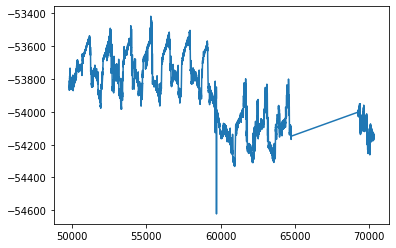

In [86]:
plt.plot(COR_df['IGRFMAG1']-COR_df['UNCOMPMAG5'])

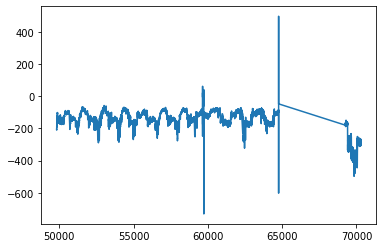

In [88]:
plt.plot(COR_df['IGRFMAG1']-COR_df['TL_comp_mag5_sq'])

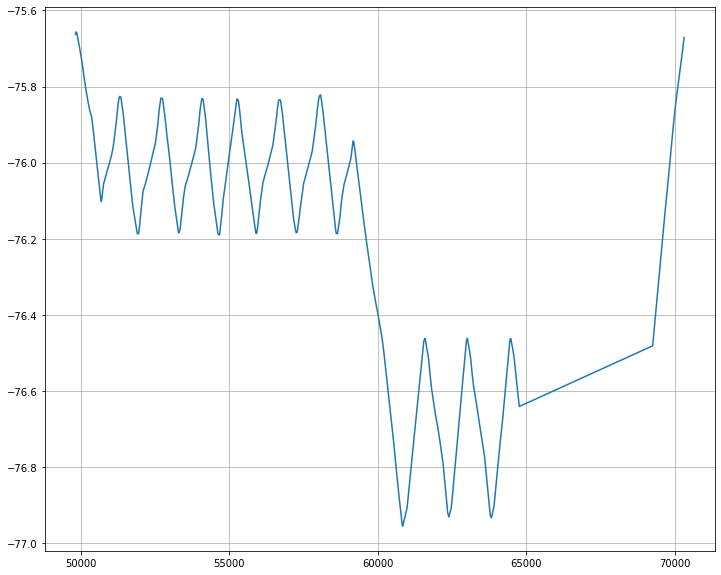

In [215]:
fig, ax = plt.subplots(figsize=[12,10])
ax.plot(COR_df['LONG']) #1350s period
ax.grid()

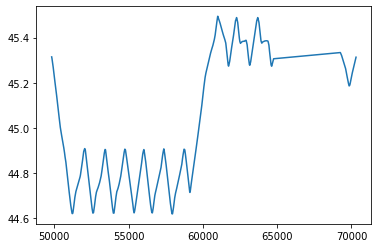

In [87]:
plt.plot(COR_df['LAT'])

# 8 - Final Dataset

## 8.1 - Challenge solution Dataset

In [ ]:
for n in tqdm(range(2,6)):
    
    df = pd.read_hdf('../data/interim/Flt_data.h5', key=f'Flt100{n}')
    
    calcIGRF = df['DCMAG1']-df['IGRFMAG1'] 
    
    A = magnav.create_TL_A(df['FLUXB_X'],df['FLUXB_Y'],df['FLUXB_Z'])
    
    df['TL_comp_mag3_sq'] = np.reshape(df['UNCOMPMAG3'].tolist(),(-1,1))-np.dot(A,TL_coef_3)+np.mean(np.dot(A,TL_coef_3))
    df['TL_comp_mag4_sq'] = np.reshape(df['UNCOMPMAG4'].tolist(),(-1,1))-np.dot(A,TL_coef_4)+np.mean(np.dot(A,TL_coef_4))
    df['TL_comp_mag5_sq'] = np.reshape(df['UNCOMPMAG5'].tolist(),(-1,1))-np.dot(A,TL_coef_5)+np.mean(np.dot(A,TL_coef_5))
    
    df['TL_comp_mag3_sq'] = df['TL_comp_mag3_sq']-df['DIURNAL']-calcIGRF
    df['TL_comp_mag4_sq'] = df['TL_comp_mag4_sq']-df['DIURNAL']-calcIGRF
    df['TL_comp_mag5_sq'] = df['TL_comp_mag5_sq']-df['DIURNAL']-calcIGRF
    
    df_sol = df[['FLUXB_TOT','FLUXB_X','FLUXC_TOT','FLUXC_Y','FLUXD_Y','FLUXD_Z','TL_comp_mag3_sq',
                 'UNCOMPMAG3','TL_comp_mag4_sq','TL_comp_mag5_sq','V_CABT','LINE','IGRFMAG1']]
    
    # export to HDF5
    df_sol.to_hdf(f'../data/interim/Sol_dataset.h5',key=f'Flt100{n}')
    # export to csv
    df_sol.to_csv(f'../data/interim/Sol_dataset_csv/Flt100{n}.csv')

In [ ]:
df_sol = df_sel_flight[['FLUXB_TOT','FLUXB_X','FLUXC_TOT','FLUXC_Y','FLUXD_Y','FLUXD_Z','TL_comp_mag3_sq','UNCOMPMAG3','TL_comp_mag4_sq','TL_comp_mag5_sq','V_CABT','LINE']]
df_sol.head()

# export to HDF5
df_sol.to_hdf('../data/interim/Sol_dataset.h5',key='Flt1003')
# export to csv
df_sol.to_csv(f'../data/interim/Sol_dataset_csv/Flt1003.csv')